## AIM: Train Graph Convulation Networks (GCNs) as multiclass classification models for predicting the psychiatric diagnosis based on EEG features

GraphLambda with & without edge attributes for predicting psychiatric diagnosis with statistical features of the power per frequency band per channel group (frontal, central, parietal, occipital) and connectivity features per frequency band per channel group (l/m/r; frontal, central, ). Statistical features are calculated with EC data, EO data and a with the ratio between EC divided by EO.

Have to use features before feature selection, to maintain even dimensions for each graph. Stat features are standardized before training. Models are tuned using multi-objective Optuna, maximizing val f1 and minimizing val loss

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import optuna

import lightning.pytorch as pl
import torch
import torch_geometric
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, Dropout1d
from torch_geometric.nn import  GCNConv, global_add_pool,GATConv,GINConv, GATv2Conv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx, to_networkx
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
from lightning.pytorch.tuner import Tuner
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar, RichProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_rank
from optuna.visualization.matplotlib import plot_slice
from optuna.visualization.matplotlib import plot_timeline

### Load data & features

In [2]:
import pickle
def load_file(file):
    with open(file, 'rb') as handle:
        return pickle.load(handle)

In [3]:
# import stat & conn features without feature selection
df_stat_conn_features = pd.read_pickle(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\df_stat_conn_features.pkl')
df_stat_conn_features = df_stat_conn_features.dropna(subset=['diagnosis'])

# label encode diagnosis
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_stat_conn_features['diagnosis'])
df_stat_conn_features['diagnosis'] = le.transform(df_stat_conn_features['diagnosis'])

print(df_stat_conn_features.shape)
df_stat_conn_features.sample(3)

(2700, 1218)


ID  diagnosis  epoch  EO_l_frontal_delta_std  \
1325  sub-88037801          0      6                0.181704   
2029  sub-88058001          1      2                0.057722   
1825  sub-88053677          3      2                0.103185   

      EO_l_frontal_delta_mean  EO_l_frontal_delta_median  \
1325                 0.134139                   0.134139   
2029                 0.085834                   0.085834   
1825                 0.086916                   0.086916   

      EO_l_frontal_delta_skew  EO_l_frontal_delta_kurt  \
1325                 2.734853                 7.361580   
2029                 1.309859                 1.710667   
1825                 3.164824                11.311971   

      EO_l_frontal_theta_std  EO_l_frontal_theta_mean  ...  \
1325                0.051740                 0.052910  ...   
2029                0.028783                 0.053247  ...   
1825                0.048797                 0.057178  ...   

      ratio_gamma_m_central-r_central  ratio_gamma_m_central-l_posterior  \
1325                         0.987800                           0.998535   
2029                         0.981276                           0.993575   
1825                         1.083690                           1.114136   

      ratio_gamma_m_central-m_posterior  ratio_gamma_m_central-r_posterior  \
1325                           0.987140                           0.989984   
2029                           0.993129                           0.994439   
1825                           1.111182                           1.125347   

      ratio_gamma_r_central-l_posterior  ratio_gamma_r_central-m_posterior  \
1325                           1.041451                           1.028229   
2029                           0.993657                           0.997214   
1825                           1.172599                           1.139293   

      ratio_gamma_r_central-r_posterior  ratio_gamma_l_posterior-m_posterior  \
1325                           1.002390                             1.010952   
2029                           0.995556                             0.999233   
1825                           1.105067                             1.099601   

      ratio_gamma_l_posterior-r_posterior  ratio_gamma_m_posterior-r_posterior  
1325                             1.022285                             1.010979  
2029                             1.012327                             1.016004  
1825                             1.129677                             1.075964  

[3 rows x 1218 columns]

In [4]:
# create 3 feature sets [EC, EO, ratio] with column ['ID', 'age', 'gender', 'diagnosis', 'epoch']
df_stat_conn_features_ec = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EO') | df_stat_conn_features.columns.str.startswith('ratio'))]]
df_stat_conn_features_eo = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EC') | df_stat_conn_features.columns.str.startswith('ratio'))]]
df_stat_conn_features_ratio = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EC') | df_stat_conn_features.columns.str.startswith('EO'))]]
print(df_stat_conn_features_ratio.shape)
print(df_stat_conn_features_ec.shape)
print(df_stat_conn_features_eo.shape)

(2700, 408)
(2700, 408)
(2700, 408)


In [5]:
synchrony_feature_dict = load_file(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\synchrony_feature_dict.pkl')
subjects_ec_syncro_matrices = synchrony_feature_dict['EC_syncro']
subjects_eo_syncro_matrices = synchrony_feature_dict['EO_syncro']
subjects_ec_ids = synchrony_feature_dict['EC_IDs']
subjects_eo_ids = synchrony_feature_dict['EO_IDs']
print(len(subjects_ec_syncro_matrices), len(subjects_eo_syncro_matrices))
print(len(subjects_ec_ids), len(subjects_eo_ids))
print(subjects_ec_syncro_matrices[0].shape)
print(subjects_ec_ids[0])

224 225
224 225
(12, 5, 9, 9)
sub-87964717


In [6]:
# compute ratio [EC/EO] synchrony matrices

# Convert the lists to sets
subjects_ec_ids_set = set(subjects_ec_ids)
subjects_eo_ids_set = set(subjects_eo_ids)

# find the missing IDs to make sure ratio is computed within the same participant
missing_ids = subjects_eo_ids_set - subjects_ec_ids_set
missing_ids_indices = [subjects_eo_ids.index(id) for id in missing_ids]

# remove missing IDs from EO
ratio_subjects_eo_syncro_matrices = [matrix for i, matrix in enumerate(subjects_eo_syncro_matrices) if i not in missing_ids_indices]
assert len(ratio_subjects_eo_syncro_matrices) == len(subjects_ec_syncro_matrices)

# compute ratio
subjects_ratio_syncro_matrices = []
for i in range(len(subjects_ec_syncro_matrices)):
    ratio_matrix = subjects_ec_syncro_matrices[i] / ratio_subjects_eo_syncro_matrices[i]
    subjects_ratio_syncro_matrices.append(ratio_matrix)
subjects_ratio_ids = subjects_ec_ids
print(len(subjects_ratio_syncro_matrices), len(subjects_ratio_ids))

224 224


C:\Users\tuur\AppData\Local\Temp\ipykernel_15272\1473655494.py:18: RuntimeWarning: invalid value encountered in divide
  ratio_matrix = subjects_ec_syncro_matrices[i] / ratio_subjects_eo_syncro_matrices[i]


In [7]:
# define function to store features in PyTorch Geometric Data objects
import networkx as nx
from joblib import Parallel, delayed # for parallel processing
from tqdm import tqdm
def process_subject(syncros, subject_id, df_features):
    graph_dataset = []
    y_list = []

    # obtain statistical features for subject
    subject_stat_features = df_features[df_features['ID'] == subject_id]
    stat_columns = ['epoch', 'mean', 'median', 'std', 'kurt', 'skew'] # select statistical features
    pattern = '|'.join(stat_columns)  # create a pattern string
    subject_stat_features = subject_stat_features[subject_stat_features.columns[subject_stat_features.columns.str.contains(pattern)]]
    
    for epoch, syncro_matrices in enumerate(syncros):
        num_edges = int((syncro_matrices.shape[1] * (syncro_matrices.shape[2] - 1)) / 2)
        bands = syncro_matrices.shape[0]
        edge_attrs = np.zeros((num_edges, bands)) # create empty array to store edge weights for each frequency band

        for i, syncro_matrix in enumerate(syncro_matrices):
            # print(f'{syncro_matrix.shape = }')
            syncro_graph = nx.from_numpy_array(syncro_matrix)
            # print(f'{syncro_graph = }')
            edge_list = nx.to_pandas_edgelist(syncro_graph)
            edge_list = edge_list.dropna(axis=0)
            # print(f'{edge_list = }')
            edge_index = edge_list.iloc[:,0:2].values.T # shape (2, num_edges), edge_index stays the same for all bands right?
            # print(f'{edge_index = }')
            edge_attr = edge_list.iloc[:,2].values#.reshape(-1,1)
            edge_attrs[:,i] = edge_attr

        y = df_stat_conn_features_ec[df_stat_conn_features_ec['ID'] == subject_id]['diagnosis'].values[0]
        
        # store statistical features for subject
        ch_groups = ['l_frontal', 'm_frontal', 'r_frontal', 'l_central', 'm_central', 'r_central', 'l_posterior', 'm_posterior', 'r_posterior']
        bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
        x = np.zeros((len(ch_groups), len(bands) * (len(stat_columns)-1))) # -1 because of epochs column in stat_columns
        # print(x.shape)
        for num, ch_group in enumerate(ch_groups):
            x[num] = subject_stat_features[subject_stat_features['epoch'] == (epoch + 1)][subject_stat_features.columns[subject_stat_features.columns.str.contains(ch_group)]].values[0]
            

        data = Data(x=torch.tensor(x, dtype=torch.float),                     # Node features [num_nodes, num_node_features]
                    edge_index=torch.tensor(edge_index, dtype=torch.long),    # Adjacency matrix [2, num_edges]
                    edge_attr=torch.tensor(edge_attrs,dtype=torch.float),  # Edge features [num_edges, num_edge_features]
                    y=torch.tensor([y], dtype=torch.long))                    # Target/Label (it should be a list) --> torch.long for classification, torch.float for regression
        graph_dataset.append(data)
        y_list.append(y)

    return graph_dataset, y_list

In [8]:
# retrieve and store data for EC features
# subjects__ec/eo_syncro_matrices : A list of lists, every list is a subject, every element in that list is an array of shape [n_epochs, n_bands, n_channels, n_channels]

results = Parallel(n_jobs=-1)(delayed(process_subject)(syncros, subject_id, df_stat_conn_features_ec) for syncros, subject_id in tqdm(zip(subjects_ec_syncro_matrices, subjects_ec_ids), total=len(subjects_ec_syncro_matrices)))

ec_graph_dataset = []
ec_y_list = []
for result in results:
    ec_graph_dataset.extend(result[0])
    ec_y_list.extend(result[1])
    
assert len(ec_graph_dataset) == len(ec_y_list)

print(f'{ec_graph_dataset[0].x.shape = }, stat features [num_nodes, num_node_features]')
print(f'{ec_graph_dataset[0].edge_attr.shape = }, [num_edges, n_bands]')
print(f'{ec_graph_dataset[0].edge_index.shape = }, [2, num_edges]')
print(f'{len(ec_graph_dataset) = }, subjects: {len(subjects_ec_syncro_matrices)}, epochs: {len(subjects_ec_syncro_matrices[0])}')
print(f'{ec_graph_dataset[0] = }')

100%|██████████| 224/224 [00:20<00:00, 10.72it/s]


ec_graph_dataset[0].x.shape = torch.Size([9, 25]), stat features [num_nodes, num_node_features]
ec_graph_dataset[0].edge_attr.shape = torch.Size([36, 5]), [num_edges, n_bands]
ec_graph_dataset[0].edge_index.shape = torch.Size([2, 36]), [2, num_edges]
len(ec_graph_dataset) = 2688, subjects: 224, epochs: 12
ec_graph_dataset[0] = Data(x=[9, 25], edge_index=[2, 36], edge_attr=[36, 5], y=[1])


In [9]:
# retrieve and store data for EO features
# subjects__ec/eo_syncro_matrices : A list of lists, every list is a subject, every element in that list is an array of shape [n_epochs, n_bands, n_channels, n_channels]

results = Parallel(n_jobs=-1)(delayed(process_subject)(syncros, subject_id, df_stat_conn_features_eo) for syncros, subject_id in tqdm(zip(subjects_eo_syncro_matrices, subjects_eo_ids), total=len(subjects_eo_syncro_matrices)))

eo_graph_dataset = []
eo_y_list = []
for result in results:
    eo_graph_dataset.extend(result[0])
    eo_y_list.extend(result[1])
    
assert len(eo_graph_dataset) == len(eo_y_list)

print(f'{eo_graph_dataset[0].x.shape = }, stat features [num_nodes, num_node_features]')
print(f'{eo_graph_dataset[0].edge_attr.shape = }, [num_edges, n_bands]')
print(f'{eo_graph_dataset[0].edge_index.shape = }, [2, num_edges]')
print(f'{len(eo_graph_dataset) = }, subjects: {len(subjects_eo_syncro_matrices)}, epochs: {len(subjects_eo_syncro_matrices[0])}')
print(f'{eo_graph_dataset[0] = }')

100%|██████████| 225/225 [00:05<00:00, 37.74it/s]


eo_graph_dataset[0].x.shape = torch.Size([9, 25]), stat features [num_nodes, num_node_features]
eo_graph_dataset[0].edge_attr.shape = torch.Size([36, 5]), [num_edges, n_bands]
eo_graph_dataset[0].edge_index.shape = torch.Size([2, 36]), [2, num_edges]
len(eo_graph_dataset) = 2700, subjects: 225, epochs: 12
eo_graph_dataset[0] = Data(x=[9, 25], edge_index=[2, 36], edge_attr=[36, 5], y=[1])


In [10]:
# retrieve and store data for EO features
# subjects__ec/eo_syncro_matrices : A list of lists, every list is a subject, every element in that list is an array of shape [n_epochs, n_bands, n_channels, n_channels]

results = Parallel(n_jobs=-1)(delayed(process_subject)(syncros, subject_id, df_stat_conn_features_ratio) for syncros, subject_id in tqdm(zip(subjects_ratio_syncro_matrices, subjects_ratio_ids), total=len(subjects_ratio_syncro_matrices)))

# process_subject(subjects_ratio_syncro_matrices[0], subjects_ratio_ids[0])

ratio_graph_dataset = []
ratio_y_list = []
for result in results:
    ratio_graph_dataset.extend(result[0])
    ratio_y_list.extend(result[1])
    
assert len(ratio_graph_dataset) == len(ratio_y_list)

print(f'{ratio_graph_dataset[0].x.shape = }, stat features [num_nodes, num_node_features]')
print(f'{ratio_graph_dataset[0].edge_attr.shape = }, [num_edges, n_bands]')
print(f'{ratio_graph_dataset[0].edge_index.shape = }, [2, num_edges]')
print(f'{len(ratio_graph_dataset) = }, subjects: {len(subjects_ratio_syncro_matrices)}, epochs: {len(subjects_ratio_syncro_matrices[0])}')
print(f'{ratio_graph_dataset[0] = }')

100%|██████████| 224/224 [00:07<00:00, 31.93it/s]


ratio_graph_dataset[0].x.shape = torch.Size([9, 25]), stat features [num_nodes, num_node_features]
ratio_graph_dataset[0].edge_attr.shape = torch.Size([36, 5]), [num_edges, n_bands]
ratio_graph_dataset[0].edge_index.shape = torch.Size([2, 36]), [2, num_edges]
len(ratio_graph_dataset) = 2688, subjects: 224, epochs: 12
ratio_graph_dataset[0] = Data(x=[9, 25], edge_index=[2, 36], edge_attr=[36, 5], y=[1])


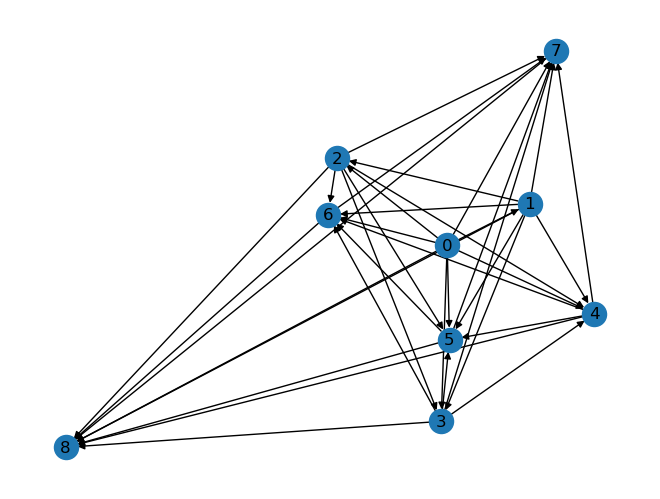

In [11]:
nx.draw(to_networkx(ratio_graph_dataset[0]), with_labels=True)

In [12]:
# load the indices of the validation sets from the ML models
data_split_indices = load_file('data_split_indices.pkl')

# GCN models:

### GCNConv with log_softmax activation function and NLLLoss

In [13]:
#Model
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
from torch.nn import Dropout1d
import seaborn as sns
import matplotlib.pyplot as plt

n_features = 25 # [Delta, Theta, Alpha, Beta, Gamma] * [mean, median, std, skew, kurt]
param = 64
num_classes = 5 # healthy, ADHD, MDD, OCD, SMC

class GCN(pl.LightningModule):
    def __init__(self, learning_rate, optimizer_name, dropout):
        super(GCN, self).__init__()
        self.learning_rate = learning_rate
        self.optimizer_name = optimizer_name

        self.conv1 = GCNConv(n_features, param, cached=False) # if you defined cache=True, the shape of batch must be same!
        self.bn1 = BatchNorm1d(param)
        self.do1 = Dropout1d(p=dropout)
        self.conv2 = GCNConv(param, param, cached=False)
        self.bn2 = BatchNorm1d(param)
        self.do2 = Dropout1d(p=dropout)
        self.fc1 = Linear(param, param)
        self.bn3 = BatchNorm1d(param)
        self.do3 = Dropout1d(p=dropout)
        self.fc2 = Linear(param, 8)
        self.fc3 = Linear(8, num_classes)

        # add metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=num_classes, average='weighted')
        self.val_f1 = F1Score(task='multiclass', num_classes=num_classes, average='weighted')
        self.val_cm = ConfusionMatrix(task = 'binary', num_classes=num_classes, threshold=0.05)
        self.validation_step_yhats = []
        self.validation_step_ys = []

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = self.do1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = self.do2(x)
        x = global_add_pool(x, data.batch)
        x = F.relu(self.fc1(x))
        x = self.bn3(x)
        x = self.do3(x)
        x = F.relu(self.fc2(x))
        #x = F.dropout(x, p=0.2, training=self.training)
        x = torch.flatten(x, start_dim=1)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1) # Activation function for classification
        return x
    
    def configure_optimizers(self):
        if self.optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError(f'Unsupported optimizer: {self.optimizer_name}')
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
            x, y = train_batch.x, train_batch.y
            output = self.forward(train_batch)
            loss = F.nll_loss(output, y)
            y_hat = output.argmax(dim=1)
            self.log('train_loss', loss, on_epoch=True, prog_bar=True)
            self.log('train_f1', self.train_f1(y, y_hat), on_epoch=True, prog_bar=True)
            return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch.x, val_batch.y
        output = self.forward(val_batch)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        self.validation_step_yhats.append(y_hat)
        self.validation_step_ys.append(y)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch.x, test_batch.y
        output = self.forward(test_batch)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss

    # def on_train_epoch_end(self, training_step_outputs):
    #     # compute metrics
    #     train_f1 = self.train_f1.compute()
    #     # log metrics
    #     self.log("epoch_train_f1", train_f1)
    #     # reset all metrics
    #     self.train_f1.reset()
    #     print(f"\nf1: {train_f1:.4}")

    # def on_validation_epoch_end(self):
    #     # plot confusion matrix
    #     y_hat = torch.cat(self.validation_step_yhats)
    #     y = torch.cat(self.validation_step_ys)
    #     confusion_matrix = self.val_cm(y_hat, y.int())

    #     confusion_matrix_computed = confusion_matrix.detach().cpu().numpy().astype(int)

    #     df_cm = pd.DataFrame(confusion_matrix_computed)
    #     plt.figure(figsize = (10,7))
    #     fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
    #     plt.close(fig_)
    #     self.loggers[0].experiment.add_figure("Confusion matrix", fig_, self.current_epoch)

    #     self.validation_step_yhats.clear() # free memory
    #     self.validation_step_ys.clear()
    
    def predict_step(self, batch):
        x, y = batch.x, batch.y
        output = self.forward(batch)
        y_hat = output.argmax(dim=1)
        return y_hat


    # def backward(self, trainer, loss, optimizer, optimizer_idx):
    #     loss.backward()
    
    # def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx):
    #     optimizer.step()
    #     optimizer.zero_grad()

# 1. EC feature set

In [14]:
from sklearn.model_selection import StratifiedGroupKFold

baseline_rest_idxs = data_split_indices['EC'][0]
baseline_val_idxs = data_split_indices['EC'][1]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_ec_ids for i in range(12)] # times 12 for each epoch

print(f'{len(ec_graph_dataset) = }')
print(f'{len(baseline_rest_idxs) = }, {len(baseline_val_idxs) = }, total: {len(baseline_rest_idxs)+len(baseline_val_idxs)}')

X_traintest = [ec_graph_dataset[i] for i in baseline_rest_idxs] 
X_val = [ec_graph_dataset[i] for i in baseline_val_idxs]
Y_traintest =[ec_y_list[i] for i in baseline_rest_idxs]
Y_val = [ec_y_list[i] for i in baseline_val_idxs]
groups_traintest = [groups[i] for i in baseline_rest_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]

# now splitting the test and training data with seperate StratifiedGroupKFold
desired_test_ratio = 0.20
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)  # should shuffle be true?

train_idxs, test_idxs = sgkf.split(X_traintest, Y_traintest, groups_traintest).__next__() # just take the first split
print(f'{len(X_traintest) = }, {len(X_val) = }')
print(f'{len(train_idxs) = }, {len(test_idxs) = }, total: {len(train_idxs)+len(test_idxs)}')

X_train = [X_traintest[i] for i in train_idxs] # X also includes y values, because they are stored in the Data object
X_test = [X_traintest[i] for i in test_idxs]
Y_train =[Y_traintest[i] for i in train_idxs]
Y_test = [Y_traintest[i] for i in test_idxs]

len(ec_graph_dataset) = 2688
len(baseline_rest_idxs) = 2148, len(baseline_val_idxs) = 540, total: 2688
len(X_traintest) = 2148, len(X_val) = 540
len(train_idxs) = 1716, len(test_idxs) = 432, total: 2148


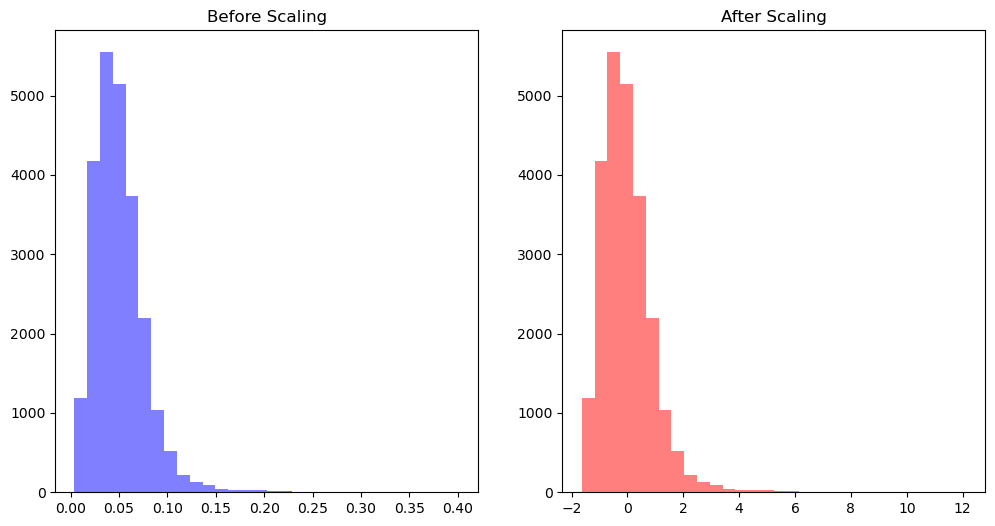

In [15]:
# standardize statistical node features
from sklearn.preprocessing import StandardScaler

# Concatenate all x values before scaling for the first feature, as a sanity check for standardization
x_before = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

scaler = StandardScaler()
scaler.fit(np.vstack([data.x.numpy() for data in X_train + X_val]))


# Transform the x values of the data in X_train
for data in X_train:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_val
for data in X_val:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_test
for data in X_test:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Concatenate all x values after scaling for the first feature, as a sanity check for standardization
x_after = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

# Plot the distribution of the first x feature before and after scaling as a sanity check
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_before, bins=30, color='b', alpha=0.5)
plt.title('Before Scaling')

plt.subplot(1, 2, 2)
plt.hist(x_after, bins=30, color='r', alpha=0.5)
plt.title('After Scaling')

plt.show()

### Model: Standard GCN

In [16]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import RichProgressBar
import logging
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

def objective(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    batch_size = trial.suggest_categorical('batch_size', [170, 340, 510, 680, 850])
    dropout = trial.suggest_float('dropout', 0, 0.8)
    hyperparameters = dict(learning_rate=learning_rate, optimizer_name=optimizer_name, batch_size=batch_size, dropout=dropout)
    print(f'Tested parameters: {hyperparameters}')
    n_epochs = batch_size * 4 # vary training epochs based on batch size

    # Create the model
    model = GCN(learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout)

    

    # Create the PyTorch Lightning trainer
    trainer = Trainer(
        accelerator='gpu',
        devices=1,
        max_epochs=n_epochs,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_f1")],
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=True,
        enable_checkpointing=False
    )

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                              drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                            drop_last=True) # , num_workers=0, persistent_workers=True

    # Log the hyperparameters
    trainer.logger.log_hyperparams(hyperparameters)

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Evaluate the model
    val_f1 = trainer.callback_metrics["val_f1"].item()

    return val_f1

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.ThresholdPruner(lower=0.1, n_warmup_steps=100))
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

df = study.trials_dataframe()
df.to_pickle('ec_results_stand_GCN_trials.pkl')

[I 2024-06-06 13:47:48,848] A new study created in memory with name: no-name-97b75ab0-4983-40ca-a7d5-d9f05e6770fd


Tested parameters: {'learning_rate': 1.0558587363143501e-05, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.1836733809657071}


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
[I 2024-06-06 13:48:00,139] Trial 0 finished with value: 0.30860385298728943 and parameters: {'learning_rate': 1.0558587363143501e-05, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.1836733809657071}. Best is trial 0 with value: 0.30860385298728943.
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.01660886063697544, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.41088840636929025}


[I 2024-06-06 13:48:14,370] Trial 1 finished with value: 0.3024803400039673 and parameters: {'learning_rate': 0.01660886063697544, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.41088840636929025}. Best is trial 0 with value: 0.30860385298728943.
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.00042032807359418617, 'optimizer_name': 'SGD', 'batch_size': 680, 'dropout': 0.1955120186405151}


[I 2024-06-06 13:48:22,487] Trial 2 finished with value: 0.2896084189414978 and parameters: {'learning_rate': 0.00042032807359418617, 'optimizer': 'SGD', 'batch_size': 680, 'dropout': 0.1955120186405151}. Best is trial 0 with value: 0.30860385298728943.


Best trial:
  Value: 0.30860385298728943
  Params: 
    learning_rate: 1.0558587363143501e-05
    optimizer: RMSprop
    batch_size: 340
    dropout: 0.1836733809657071


In [17]:
df_trials = pd.read_pickle('ec_results_stand_GCN_trials.pkl')
df_trials.sort_values('value', ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
0       0  0.308604 2024-06-06 13:47:48.850165 2024-06-06 13:48:00.139446   
1       1  0.302480 2024-06-06 13:48:00.140445 2024-06-06 13:48:14.369413   
2       2  0.289608 2024-06-06 13:48:14.370414 2024-06-06 13:48:22.487807   

                duration  params_batch_size  params_dropout  \
0 0 days 00:00:11.289281                340        0.183673   
1 0 days 00:00:14.228968                170        0.410888   
2 0 days 00:00:08.117393                680        0.195512   

   params_learning_rate params_optimizer     state  
0              0.000011          RMSprop  COMPLETE  
1              0.016609             Adam  COMPLETE  
2              0.000420              SGD  COMPLETE

#### Visualizations

In [18]:
# function to change axes size
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

/tmp/ipykernel_41868/1755039964.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

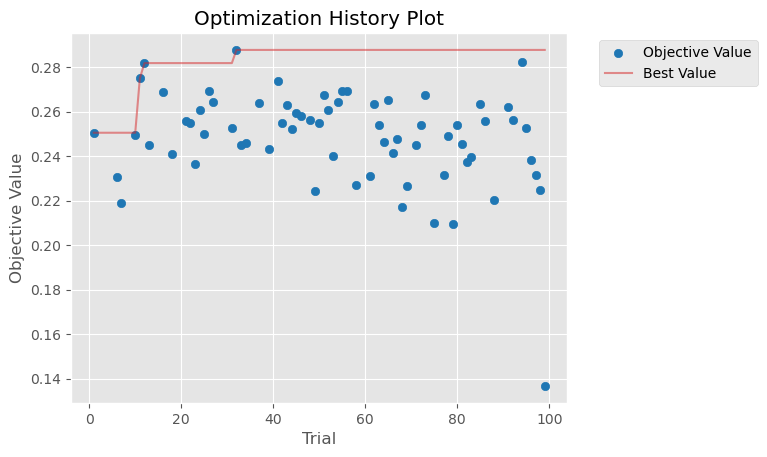

In [19]:
# Visualize the optimization history
plot_optimization_history(study)

[I 2024-05-22 19:47:27,928] A new study created in memory with name: no-name-f7ff26a4-b81e-4f6a-bbaa-1050c4fd492f
/tmp/ipykernel_41868/1240065685.py:7: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  plot_intermediate_values(plotted_study)


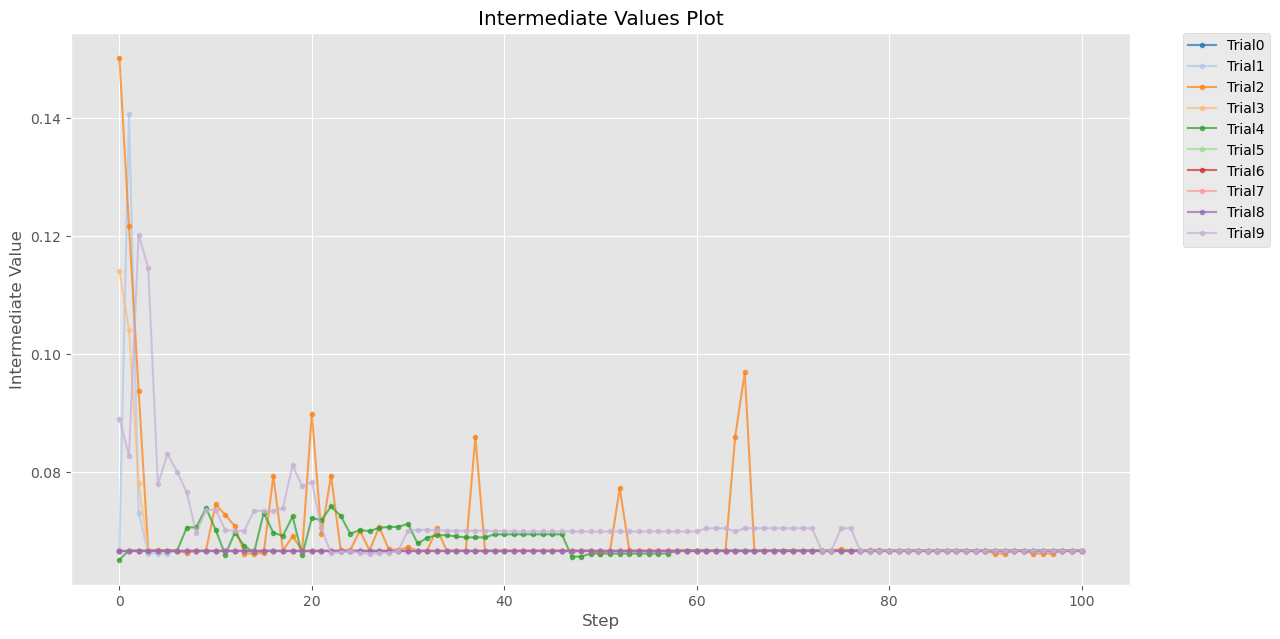

In [20]:
# Visualize the learning curves of the best 10 trials
trials = study.trials
plotted_trials = sorted(trials, key=lambda t: t.value, reverse=True)[:10]
plotted_study = optuna.create_study()
for trial in plotted_trials:
    plotted_study.add_trial(trial)
plot_intermediate_values(plotted_study)
set_size(10, 5)

/tmp/ipykernel_41868/2919792376.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


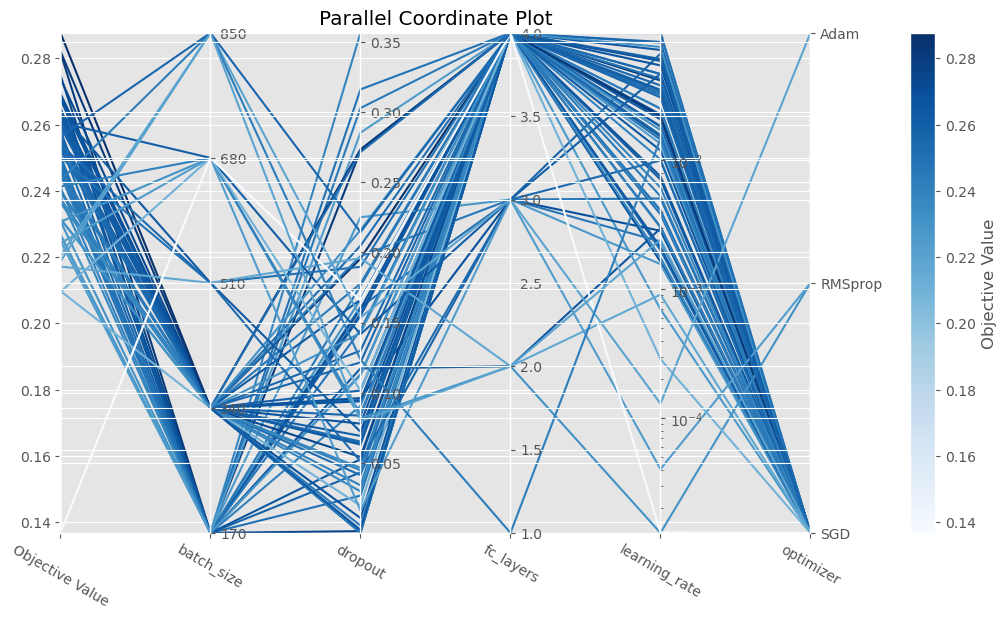

In [21]:
# Visualize high-dimensional parameter relationships.
plot_parallel_coordinate(study)
set_size(10, 5)

/tmp/ipykernel_41868/624402143.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2024-05-22 19:47:29,134] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


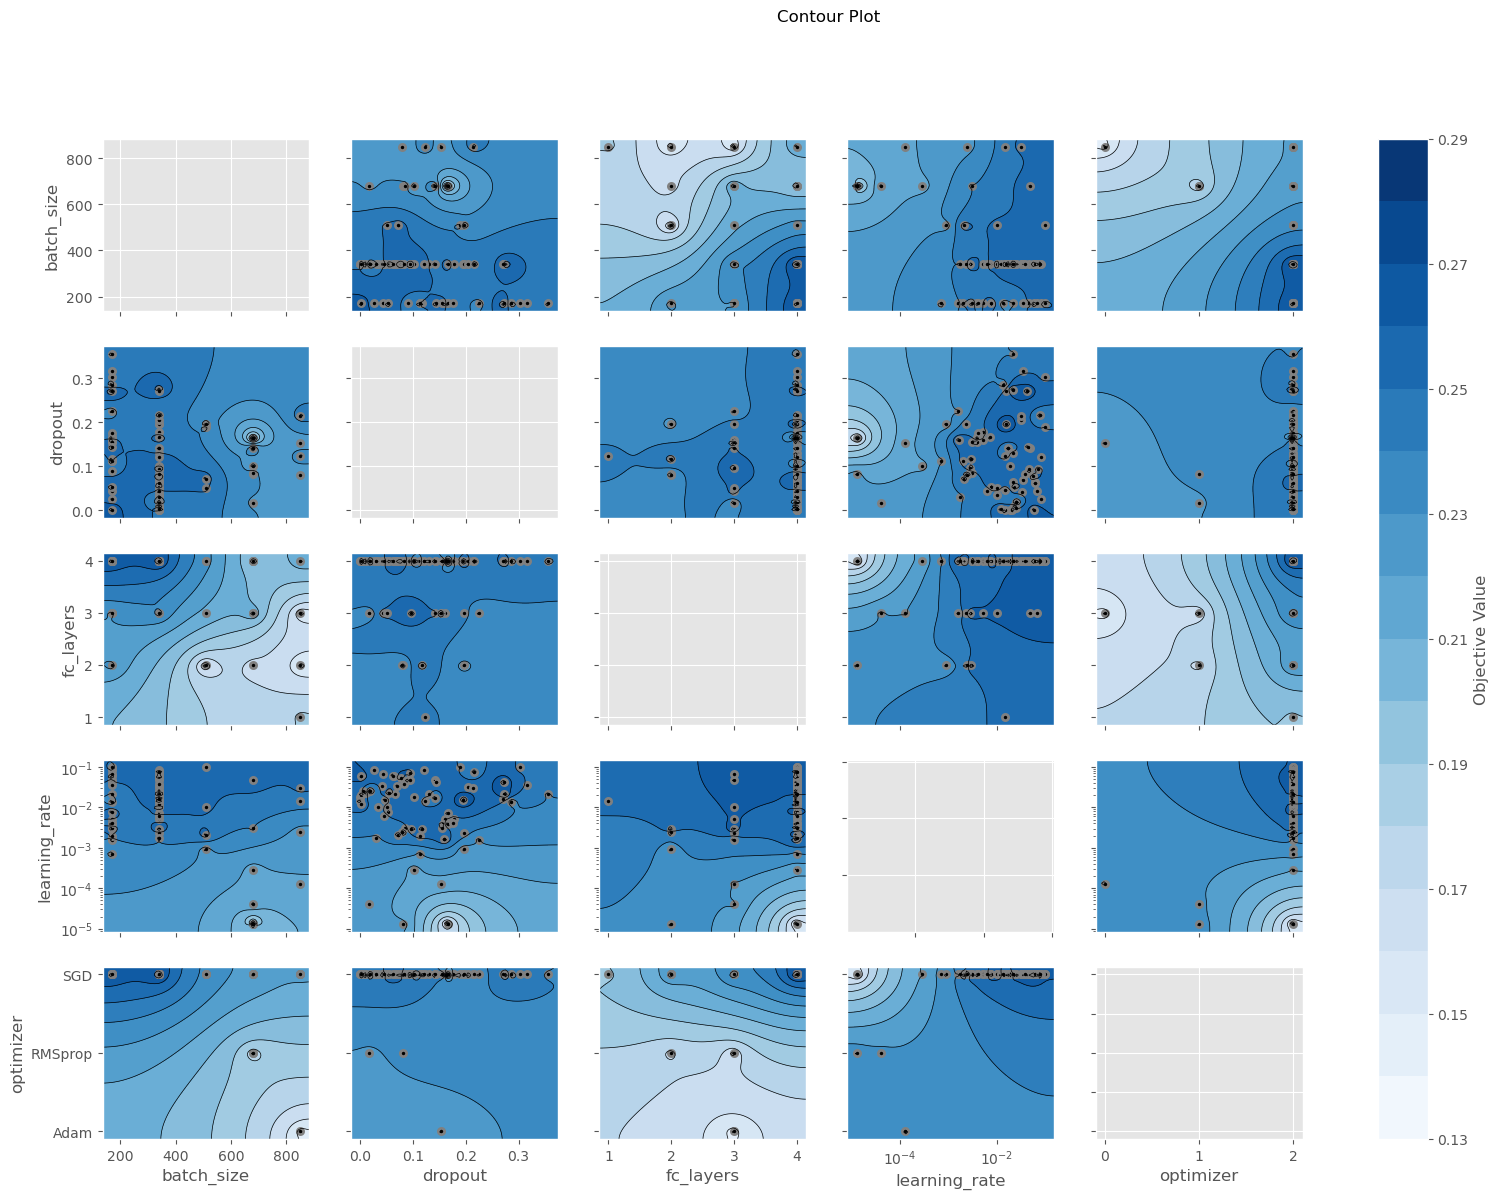

In [22]:
# Visualize hyperparameter relationships
plot_contour(study)
set_size(15, 10)

/tmp/ipykernel_41868/1888575690.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<Axes: xlabel='batch_size', ylabel='Objective Value'>,
       <Axes: xlabel='dropout'>, <Axes: xlabel='fc_layers'>,
       <Axes: xlabel='learning_rate'>, <Axes: xlabel='optimizer'>],
      dtype=object)

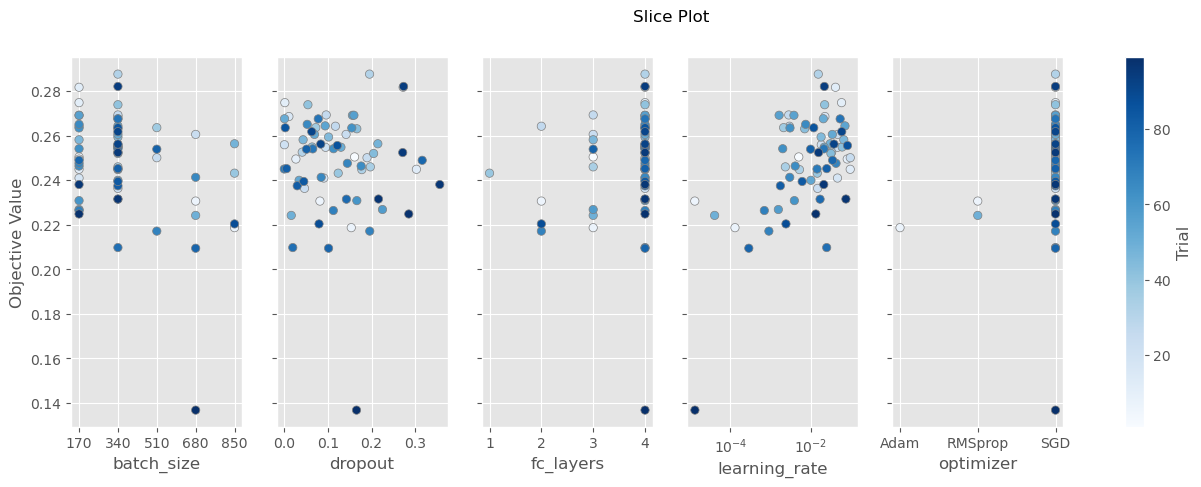

In [23]:
# Visualize individual hyperparameters as slice plot
plot_slice(study)

/tmp/ipykernel_41868/1473508994.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

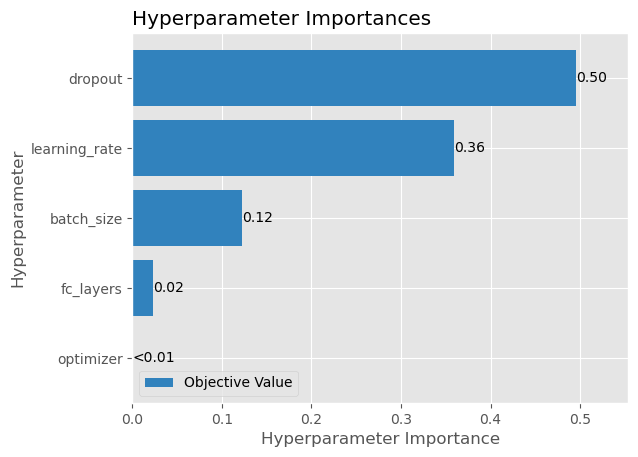

In [24]:
# Visualize parameter importances.
plot_param_importances(study)

/tmp/ipykernel_41868/3113371256.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

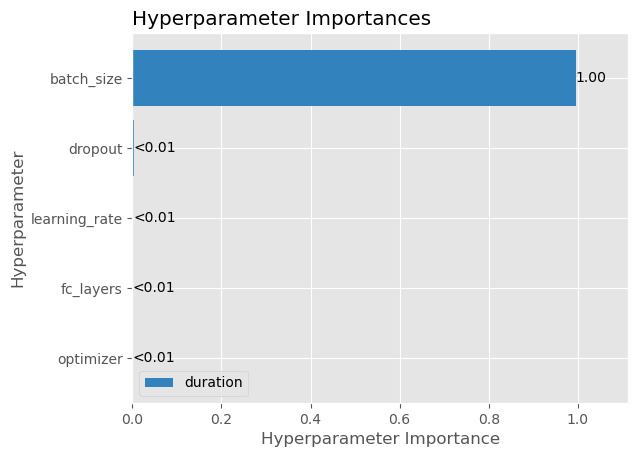

In [25]:
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

/tmp/ipykernel_41868/1828777839.py:2: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  plot_edf(study)


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

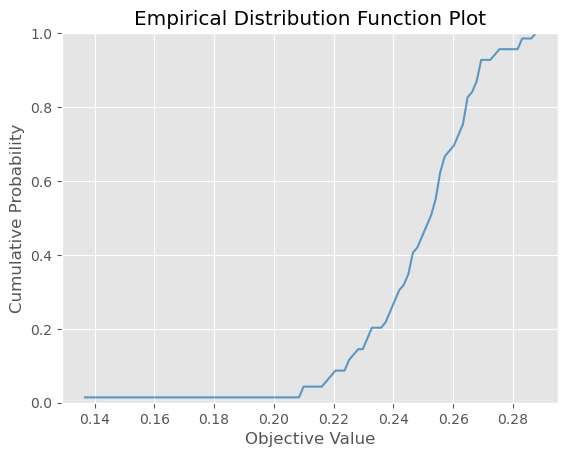

In [26]:
# Visualize empirical distribution function.
plot_edf(study)

/tmp/ipykernel_41868/1172520691.py:2: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  plot_rank(study)
[W 2024-05-22 19:47:37,319] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


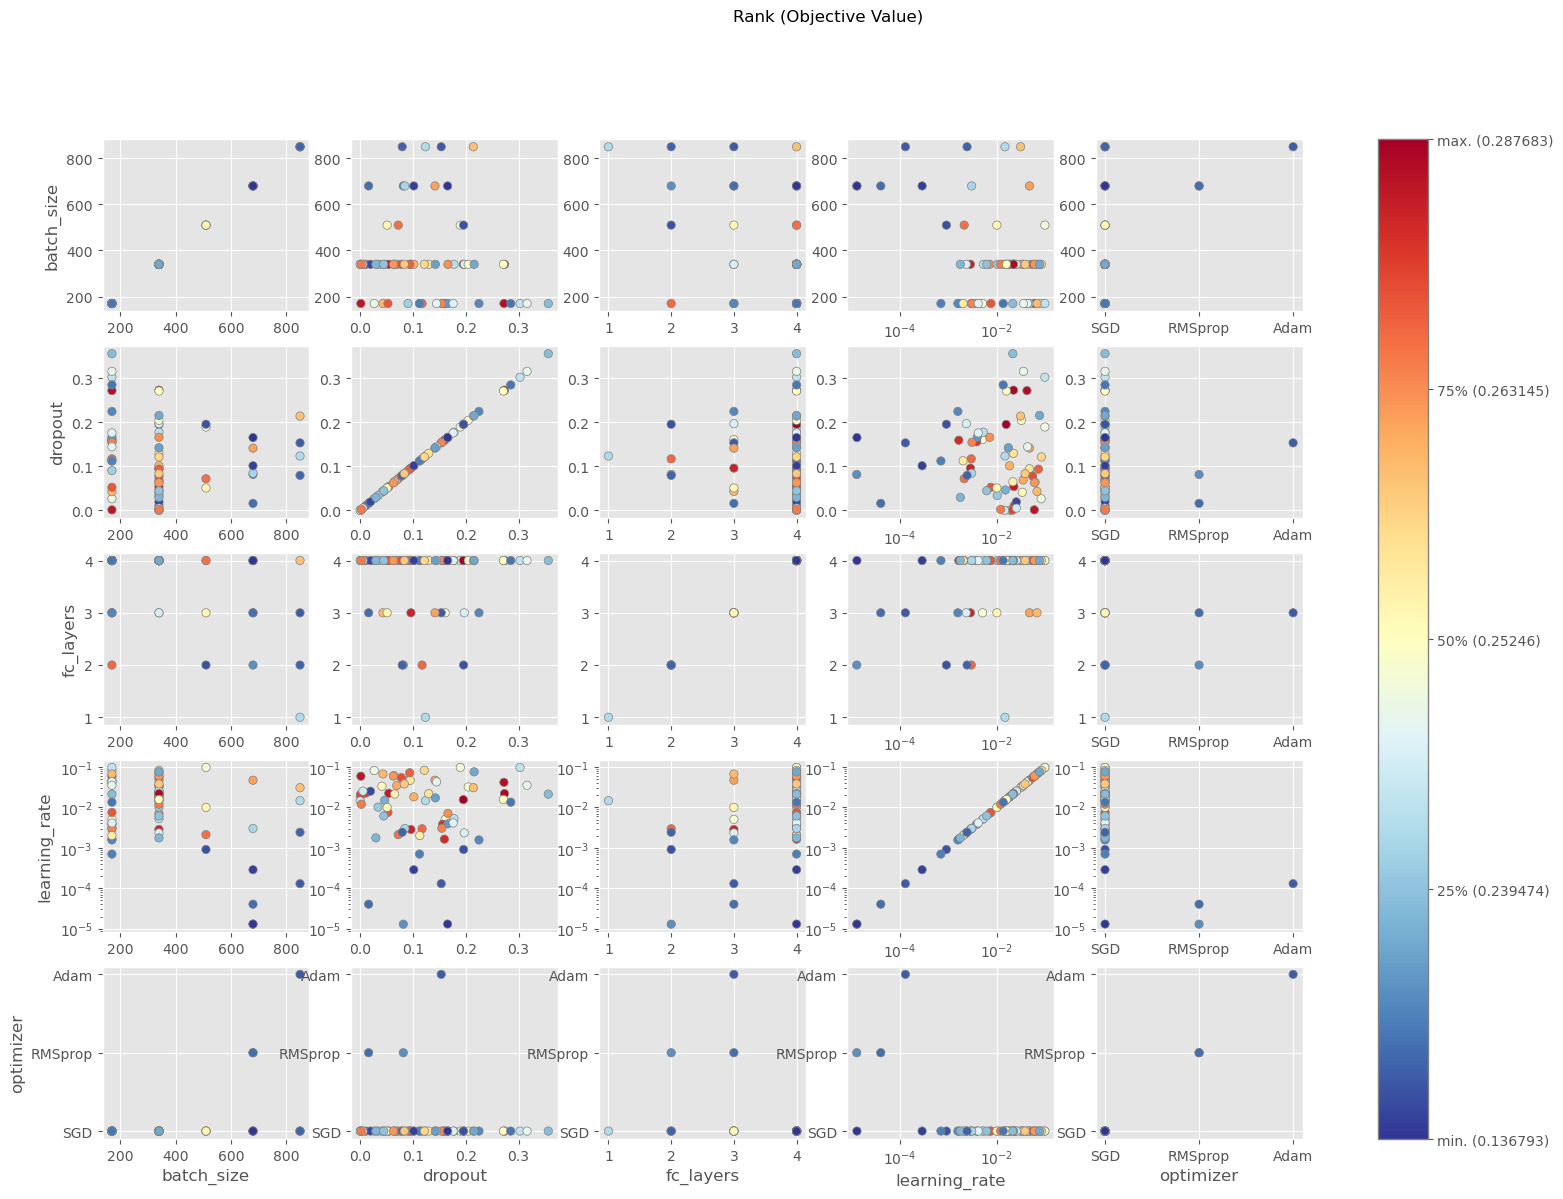

In [27]:
# Visualize parameter relations with scatter plots colored by objective values.
plot_rank(study)
set_size(15, 10)

/tmp/ipykernel_41868/124343896.py:2: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  plot_timeline(study)


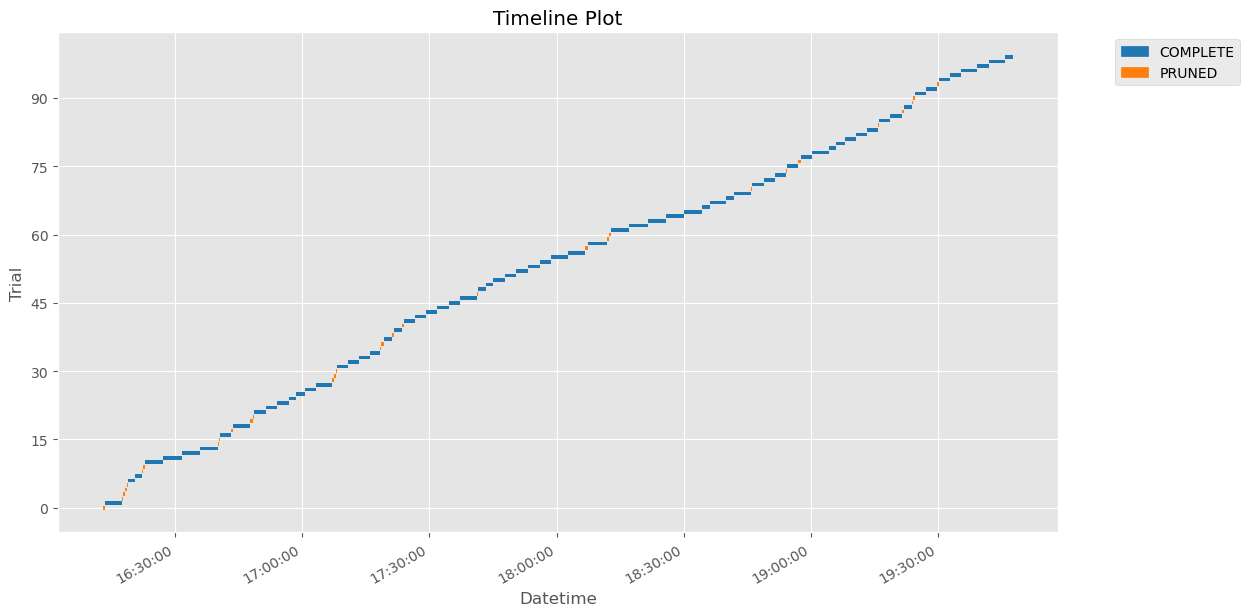

In [28]:
# Visualize the optimization timeline of performed trials.
plot_timeline(study)
set_size(10, 5)

In [29]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import RichProgressBar
import logging
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

def objective(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    batch_size = trial.suggest_categorical('batch_size', [170, 340, 510, 680, 850])
    fc_layers = trial.suggest_int('fc_layers', 1, 8)
    # fc_layers = 1
    dropout = trial.suggest_float('dropout', 0, 0.8)
    hyperparameters = dict(learning_rate=learning_rate, optimizer_name=optimizer_name, batch_size=batch_size, fc_layers=fc_layers, dropout=dropout)
    print(f'Tested parameters: {hyperparameters}')
    n_epochs = batch_size * 4 # vary training epochs based on batch size


    # Create the model
    model = graphLambda_w_edge_attr(learning_rate=learning_rate, optimizer_name=optimizer_name, fc_layers=fc_layers, dropout=dropout)

    

    # Create the PyTorch Lightning trainer
    trainer = Trainer(
        accelerator='gpu',
        devices=1,
        max_epochs=n_epochs,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_f1")],
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=True,
        enable_checkpointing=False
    )

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                              drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                            drop_last=True) # , num_workers=0, persistent_workers=True

    # Log the hyperparameters
    trainer.logger.log_hyperparams(hyperparameters)

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Evaluate the model
    val_f1 = trainer.callback_metrics["val_f1"].item()

    return val_f1

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.ThresholdPruner(lower=0.1, n_warmup_steps=100))
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

df = study.trials_dataframe()
df.to_pickle('ec_results_w_edge_attrs_trials.pkl')

[I 2024-05-22 19:47:40,935] A new study created in memory with name: no-name-70fc2653-ea21-48b9-89d9-21254df5ad19
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.0015083803725902893, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.16278904371460445}


[I 2024-05-22 19:51:54,817] Trial 0 finished with value: 0.2485891580581665 and parameters: {'learning_rate': 0.0015083803725902893, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.16278904371460445}. Best is trial 0 with value: 0.2485891580581665.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.018826593999143906, 'optimizer_name': 'SGD', 'batch_size': 680, 'fc_layers': 3, 'dropout': 0.3511966466307594}


[I 2024-05-22 19:53:53,821] Trial 1 finished with value: 0.2433285266160965 and parameters: {'learning_rate': 0.018826593999143906, 'optimizer': 'SGD', 'batch_size': 680, 'fc_layers': 3, 'dropout': 0.3511966466307594}. Best is trial 0 with value: 0.2485891580581665.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.012009229177790152, 'optimizer_name': 'Adam', 'batch_size': 340, 'fc_layers': 2, 'dropout': 0.7892868254548022}


[I 2024-05-22 19:54:17,051] Trial 2 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 2.6219984082816054e-05, 'optimizer_name': 'Adam', 'batch_size': 850, 'fc_layers': 4, 'dropout': 0.28727318776009775}


[I 2024-05-22 19:56:32,169] Trial 3 finished with value: 0.2228400558233261 and parameters: {'learning_rate': 2.6219984082816054e-05, 'optimizer': 'Adam', 'batch_size': 850, 'fc_layers': 4, 'dropout': 0.28727318776009775}. Best is trial 0 with value: 0.2485891580581665.


Tested parameters: {'learning_rate': 0.000819106895181796, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 4, 'dropout': 0.6944714897251745}


[I 2024-05-22 19:56:47,493] Trial 4 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0025378091919408233, 'optimizer_name': 'Adam', 'batch_size': 680, 'fc_layers': 2, 'dropout': 0.13655252083600633}


[I 2024-05-22 19:57:02,592] Trial 5 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0014634543850683202, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.2961494487990611}


[I 2024-05-22 19:57:19,369] Trial 6 pruned. Trial was pruned at epoch 111.


Tested parameters: {'learning_rate': 0.00029212424481295685, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'fc_layers': 1, 'dropout': 0.44273245859348126}


[I 2024-05-22 20:00:22,088] Trial 7 finished with value: 0.21651257574558258 and parameters: {'learning_rate': 0.00029212424481295685, 'optimizer': 'RMSprop', 'batch_size': 340, 'fc_layers': 1, 'dropout': 0.44273245859348126}. Best is trial 0 with value: 0.2485891580581665.


Tested parameters: {'learning_rate': 0.003552509060294346, 'optimizer_name': 'SGD', 'batch_size': 340, 'fc_layers': 2, 'dropout': 0.5797511103924619}


[I 2024-05-22 20:00:45,935] Trial 8 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0047591274719290125, 'optimizer_name': 'Adam', 'batch_size': 850, 'fc_layers': 1, 'dropout': 0.6060410809422137}


[I 2024-05-22 20:01:02,229] Trial 9 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0981200227471596, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.048817885679364834}


[I 2024-05-22 20:05:21,416] Trial 10 finished with value: 0.19308128952980042 and parameters: {'learning_rate': 0.0981200227471596, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.048817885679364834}. Best is trial 0 with value: 0.2485891580581665.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.06826507805422889, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.2048477550304912}


[I 2024-05-22 20:07:41,964] Trial 11 finished with value: 0.26601290702819824 and parameters: {'learning_rate': 0.06826507805422889, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.2048477550304912}. Best is trial 11 with value: 0.26601290702819824.


Tested parameters: {'learning_rate': 0.00017212272750948782, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.1641896780045078}


[I 2024-05-22 20:10:05,548] Trial 12 finished with value: 0.14526505768299103 and parameters: {'learning_rate': 0.00017212272750948782, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.1641896780045078}. Best is trial 11 with value: 0.26601290702819824.


Tested parameters: {'learning_rate': 0.09854542533608514, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.016396002650665403}


[I 2024-05-22 20:10:41,489] Trial 13 pruned. Trial was pruned at epoch 199.


Tested parameters: {'learning_rate': 0.02229009481876554, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 2, 'dropout': 0.18954444233820045}


[I 2024-05-22 20:15:06,861] Trial 14 finished with value: 0.22702187299728394 and parameters: {'learning_rate': 0.02229009481876554, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 2, 'dropout': 0.18954444233820045}. Best is trial 11 with value: 0.26601290702819824.


Tested parameters: {'learning_rate': 1.1431355092144612e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.42413389021667725}


[I 2024-05-22 20:19:29,671] Trial 15 finished with value: 0.15982533991336823 and parameters: {'learning_rate': 1.1431355092144612e-05, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.42413389021667725}. Best is trial 11 with value: 0.26601290702819824.


Tested parameters: {'learning_rate': 0.00022375435809282083, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.25931548187943293}


[I 2024-05-22 20:21:48,873] Trial 16 finished with value: 0.26897722482681274 and parameters: {'learning_rate': 0.00022375435809282083, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.25931548187943293}. Best is trial 16 with value: 0.26897722482681274.


Tested parameters: {'learning_rate': 0.00010484605897260998, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.26184672590504077}


[I 2024-05-22 20:22:20,490] Trial 17 pruned. Trial was pruned at epoch 180.


Tested parameters: {'learning_rate': 4.517092298240337e-05, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.49506890504790435}


[I 2024-05-22 20:23:18,646] Trial 18 pruned. Trial was pruned at epoch 326.


Tested parameters: {'learning_rate': 0.0005763932171355964, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.10498225503541539}


[I 2024-05-22 20:23:36,606] Trial 19 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00041915061475208634, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.23126972691411332}


[I 2024-05-22 20:25:54,967] Trial 20 finished with value: 0.22405844926834106 and parameters: {'learning_rate': 0.00041915061475208634, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.23126972691411332}. Best is trial 16 with value: 0.26897722482681274.


Tested parameters: {'learning_rate': 0.00010615666157800086, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.34237144260396657}


[I 2024-05-22 20:30:13,264] Trial 21 finished with value: 0.21752607822418213 and parameters: {'learning_rate': 0.00010615666157800086, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.34237144260396657}. Best is trial 16 with value: 0.26897722482681274.


Tested parameters: {'learning_rate': 0.03975764078038469, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.08715379041702909}


[I 2024-05-22 20:32:35,293] Trial 22 finished with value: 0.2095411717891693 and parameters: {'learning_rate': 0.03975764078038469, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.08715379041702909}. Best is trial 16 with value: 0.26897722482681274.


Tested parameters: {'learning_rate': 0.009342115321156719, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 2, 'dropout': 0.2052937131450812}


[I 2024-05-22 20:36:55,194] Trial 23 finished with value: 0.26596423983573914 and parameters: {'learning_rate': 0.009342115321156719, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 2, 'dropout': 0.2052937131450812}. Best is trial 16 with value: 0.26897722482681274.


Tested parameters: {'learning_rate': 0.005573319574786725, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.35041477934518606}


[I 2024-05-22 20:37:12,941] Trial 24 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.041590399945265, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.2576493040794402}


[I 2024-05-22 20:39:26,726] Trial 25 finished with value: 0.24621553719043732 and parameters: {'learning_rate': 0.041590399945265, 'optimizer': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.2576493040794402}. Best is trial 16 with value: 0.26897722482681274.


Tested parameters: {'learning_rate': 0.007515022084638625, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 2, 'dropout': 0.1915764897435828}


[I 2024-05-22 20:43:42,296] Trial 26 finished with value: 0.259075403213501 and parameters: {'learning_rate': 0.007515022084638625, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 2, 'dropout': 0.1915764897435828}. Best is trial 16 with value: 0.26897722482681274.


Tested parameters: {'learning_rate': 0.04593534408876605, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.22518537096416633}


[I 2024-05-22 20:46:03,272] Trial 27 finished with value: 0.24249479174613953 and parameters: {'learning_rate': 0.04593534408876605, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.22518537096416633}. Best is trial 16 with value: 0.26897722482681274.


Tested parameters: {'learning_rate': 0.010508317465136953, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.10304340675034601}


[I 2024-05-22 20:46:21,482] Trial 28 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0015248855112764735, 'optimizer_name': 'Adam', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.32806559844257865}


[I 2024-05-22 20:50:46,523] Trial 29 finished with value: 0.17696911096572876 and parameters: {'learning_rate': 0.0015248855112764735, 'optimizer': 'Adam', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.32806559844257865}. Best is trial 16 with value: 0.26897722482681274.


Tested parameters: {'learning_rate': 0.022464848559096116, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 2, 'dropout': 0.4827081265582289}


[I 2024-05-22 20:51:19,284] Trial 30 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.011872216551158207, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 2, 'dropout': 0.19693957703690018}


[I 2024-05-22 20:55:39,554] Trial 31 finished with value: 0.2352171540260315 and parameters: {'learning_rate': 0.011872216551158207, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 2, 'dropout': 0.19693957703690018}. Best is trial 16 with value: 0.26897722482681274.


Tested parameters: {'learning_rate': 0.00739030946583329, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.13416334241786115}


[I 2024-05-22 21:00:03,392] Trial 32 finished with value: 0.2268626093864441 and parameters: {'learning_rate': 0.00739030946583329, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.13416334241786115}. Best is trial 16 with value: 0.26897722482681274.


Tested parameters: {'learning_rate': 0.0024869453742316972, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 2, 'dropout': 0.1951503572179611}


[I 2024-05-22 21:04:30,598] Trial 33 finished with value: 0.2465730607509613 and parameters: {'learning_rate': 0.0024869453742316972, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 2, 'dropout': 0.1951503572179611}. Best is trial 16 with value: 0.26897722482681274.


Tested parameters: {'learning_rate': 0.020494398317661353, 'optimizer_name': 'SGD', 'batch_size': 340, 'fc_layers': 3, 'dropout': 0.37420574585389754}


[I 2024-05-22 21:07:30,293] Trial 34 finished with value: 0.24122929573059082 and parameters: {'learning_rate': 0.020494398317661353, 'optimizer': 'SGD', 'batch_size': 340, 'fc_layers': 3, 'dropout': 0.37420574585389754}. Best is trial 16 with value: 0.26897722482681274.


Tested parameters: {'learning_rate': 0.0002718740286238445, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 2, 'dropout': 0.28092607517968665}


[I 2024-05-22 21:07:46,847] Trial 35 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0692994639417977, 'optimizer_name': 'Adam', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.047740636702531036}


[I 2024-05-22 21:08:19,558] Trial 36 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0009388985513714087, 'optimizer_name': 'SGD', 'batch_size': 680, 'fc_layers': 2, 'dropout': 0.3011902994632868}


[I 2024-05-22 21:08:34,309] Trial 37 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0017665781186038498, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 4, 'dropout': 0.14882354279169777}


[I 2024-05-22 21:08:49,521] Trial 38 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.007952712313925542, 'optimizer_name': 'Adam', 'batch_size': 340, 'fc_layers': 1, 'dropout': 0.21017127644083194}


[I 2024-05-22 21:09:12,069] Trial 39 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.003199077645497327, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.24393769970405332}


[I 2024-05-22 21:11:30,822] Trial 40 finished with value: 0.22397413849830627 and parameters: {'learning_rate': 0.003199077645497327, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.24393769970405332}. Best is trial 16 with value: 0.26897722482681274.


Tested parameters: {'learning_rate': 0.0006870805659686486, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.162835148511907}


[I 2024-05-22 21:15:49,038] Trial 41 finished with value: 0.22925058007240295 and parameters: {'learning_rate': 0.0006870805659686486, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.162835148511907}. Best is trial 16 with value: 0.26897722482681274.


Tested parameters: {'learning_rate': 0.01440206314700877, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.7641818838363545}


[I 2024-05-22 21:16:20,814] Trial 42 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0012840873000652838, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.07330007766398267}


[I 2024-05-22 21:20:38,069] Trial 43 finished with value: 0.27254509925842285 and parameters: {'learning_rate': 0.0012840873000652838, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.07330007766398267}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 5.3420955790924434e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.015023547819865798}


[I 2024-05-22 21:24:54,914] Trial 44 finished with value: 0.22073166072368622 and parameters: {'learning_rate': 5.3420955790924434e-05, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.015023547819865798}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 0.004644169539633088, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.09431828431877132}


[I 2024-05-22 21:27:10,590] Trial 45 finished with value: 0.2577769458293915 and parameters: {'learning_rate': 0.004644169539633088, 'optimizer': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.09431828431877132}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 0.031270027915095526, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.0614645978144929}


[I 2024-05-22 21:27:43,871] Trial 46 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00021455136143499326, 'optimizer_name': 'SGD', 'batch_size': 680, 'fc_layers': 2, 'dropout': 0.1244265568680004}


[I 2024-05-22 21:29:42,260] Trial 47 finished with value: 0.18205571174621582 and parameters: {'learning_rate': 0.00021455136143499326, 'optimizer': 'SGD', 'batch_size': 680, 'fc_layers': 2, 'dropout': 0.1244265568680004}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 0.0023405540384646745, 'optimizer_name': 'Adam', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.1659444089750903}


[I 2024-05-22 21:34:10,649] Trial 48 finished with value: 0.18959549069404602 and parameters: {'learning_rate': 0.0023405540384646745, 'optimizer': 'Adam', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.1659444089750903}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 0.0004366710625867314, 'optimizer_name': 'SGD', 'batch_size': 340, 'fc_layers': 3, 'dropout': 0.30621597539999834}


[I 2024-05-22 21:34:33,327] Trial 49 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0626802797985741, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.40833378951451743}


[I 2024-05-22 21:34:50,504] Trial 50 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00475810778468899, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.003265427261800985}


[I 2024-05-22 21:37:03,430] Trial 51 finished with value: 0.24110758304595947 and parameters: {'learning_rate': 0.00475810778468899, 'optimizer': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.003265427261800985}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 0.0013968640170518524, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.08530652807733975}


[I 2024-05-22 21:39:19,888] Trial 52 finished with value: 0.2568150758743286 and parameters: {'learning_rate': 0.0013968640170518524, 'optimizer': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.08530652807733975}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 0.004053957197783198, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.04572897424123931}


[I 2024-05-22 21:41:33,270] Trial 53 finished with value: 0.2366846203804016 and parameters: {'learning_rate': 0.004053957197783198, 'optimizer': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.04572897424123931}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 0.007170711547272874, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.17940765239695855}


[I 2024-05-22 21:43:46,989] Trial 54 finished with value: 0.23479029536247253 and parameters: {'learning_rate': 0.007170711547272874, 'optimizer': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.17940765239695855}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 0.01608467100632771, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.12345005747665591}


[I 2024-05-22 21:46:08,772] Trial 55 finished with value: 0.24739861488342285 and parameters: {'learning_rate': 0.01608467100632771, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.12345005747665591}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 0.0010504947590626466, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 4, 'dropout': 0.2589261508671641}


[I 2024-05-22 21:46:33,444] Trial 56 pruned. Trial was pruned at epoch 144.


Tested parameters: {'learning_rate': 0.00014090425106555413, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'fc_layers': 2, 'dropout': 0.21937912597699152}


[I 2024-05-22 21:50:56,081] Trial 57 finished with value: 0.23547235131263733 and parameters: {'learning_rate': 0.00014090425106555413, 'optimizer': 'RMSprop', 'batch_size': 170, 'fc_layers': 2, 'dropout': 0.21937912597699152}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 0.00313944539862076, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.07735838824441549}


[I 2024-05-22 21:53:16,248] Trial 58 finished with value: 0.22880831360816956 and parameters: {'learning_rate': 0.00313944539862076, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.07735838824441549}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 0.027831198063044373, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.14209689122348368}


[I 2024-05-22 21:57:32,429] Trial 59 finished with value: 0.17356164753437042 and parameters: {'learning_rate': 0.027831198063044373, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.14209689122348368}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 0.0004955987449140415, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.5999696887100804}


[I 2024-05-22 21:57:50,157] Trial 60 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.001258263771939438, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.09501980681830151}


[I 2024-05-22 22:00:03,616] Trial 61 finished with value: 0.24419578909873962 and parameters: {'learning_rate': 0.001258263771939438, 'optimizer': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.09501980681830151}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 0.0007646237149369263, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.11460981583354152}


[I 2024-05-22 22:02:20,237] Trial 62 finished with value: 0.23120494186878204 and parameters: {'learning_rate': 0.0007646237149369263, 'optimizer': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.11460981583354152}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 0.0020873268143044433, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.03447638241471815}


[I 2024-05-22 22:04:31,635] Trial 63 finished with value: 0.25325530767440796 and parameters: {'learning_rate': 0.0020873268143044433, 'optimizer': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.03447638241471815}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 0.0014930308089353013, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.08695776825988419}


[I 2024-05-22 22:06:43,992] Trial 64 finished with value: 0.24825790524482727 and parameters: {'learning_rate': 0.0014930308089353013, 'optimizer': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.08695776825988419}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 0.009581479571690355, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.18093697182851884}


[I 2024-05-22 22:08:57,291] Trial 65 finished with value: 0.23633621633052826 and parameters: {'learning_rate': 0.009581479571690355, 'optimizer': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.18093697182851884}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 0.005899462883159466, 'optimizer_name': 'Adam', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.23746632541847845}


[I 2024-05-22 22:09:30,130] Trial 66 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0033064482049843494, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.15430856328091547}


[I 2024-05-22 22:11:49,987] Trial 67 finished with value: 0.2541862428188324 and parameters: {'learning_rate': 0.0033064482049843494, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.15430856328091547}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 0.0010548003775942404, 'optimizer_name': 'SGD', 'batch_size': 340, 'fc_layers': 2, 'dropout': 0.08176056714748817}


[I 2024-05-22 22:14:47,191] Trial 68 finished with value: 0.247050940990448 and parameters: {'learning_rate': 0.0010548003775942404, 'optimizer': 'SGD', 'batch_size': 340, 'fc_layers': 2, 'dropout': 0.08176056714748817}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 1.4320844707591721e-05, 'optimizer_name': 'SGD', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.28484476189430863}


[I 2024-05-22 22:16:42,481] Trial 69 finished with value: 0.21326397359371185 and parameters: {'learning_rate': 1.4320844707591721e-05, 'optimizer': 'SGD', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.28484476189430863}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 6.092074423096283e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.21127326037793132}


[I 2024-05-22 22:20:28,768] Trial 70 pruned. Trial was pruned at epoch 662.


Tested parameters: {'learning_rate': 0.0018646727422973607, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.14793365814393333}


[I 2024-05-22 22:22:47,980] Trial 71 finished with value: 0.23971349000930786 and parameters: {'learning_rate': 0.0018646727422973607, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.14793365814393333}. Best is trial 43 with value: 0.27254509925842285.


Tested parameters: {'learning_rate': 0.0036536511904474104, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.06543350071081898}


[I 2024-05-22 22:25:07,458] Trial 72 finished with value: 0.281756192445755 and parameters: {'learning_rate': 0.0036536511904474104, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.06543350071081898}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.00030951768339520375, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.056265318983168944}


[I 2024-05-22 22:27:30,436] Trial 73 finished with value: 0.22384797036647797 and parameters: {'learning_rate': 0.00030951768339520375, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.056265318983168944}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.006239220798291987, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.11101032634152835}


[I 2024-05-22 22:29:58,041] Trial 74 finished with value: 0.22979293763637543 and parameters: {'learning_rate': 0.006239220798291987, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.11101032634152835}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.004600531799623168, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.03310720322923843}


[I 2024-05-22 22:30:16,061] Trial 75 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0027901334516849292, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 2, 'dropout': 0.07678525554833932}


[I 2024-05-22 22:34:40,105] Trial 76 finished with value: 0.24477097392082214 and parameters: {'learning_rate': 0.0027901334516849292, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 2, 'dropout': 0.07678525554833932}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.009848869457850374, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.5471453951596161}


[I 2024-05-22 22:37:03,592] Trial 77 finished with value: 0.21950402855873108 and parameters: {'learning_rate': 0.009848869457850374, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.5471453951596161}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.0006110885892114759, 'optimizer_name': 'Adam', 'batch_size': 850, 'fc_layers': 2, 'dropout': 0.18781096317110682}


[I 2024-05-22 22:39:16,150] Trial 78 finished with value: 0.20784983038902283 and parameters: {'learning_rate': 0.0006110885892114759, 'optimizer': 'Adam', 'batch_size': 850, 'fc_layers': 2, 'dropout': 0.18781096317110682}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.0037487264277023505, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.3791522536339396}


[I 2024-05-22 22:39:48,775] Trial 79 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.06990923520594737, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.0190054423222355}


[I 2024-05-22 22:40:05,890] Trial 80 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0013633709219410411, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.16505091655213727}


[I 2024-05-22 22:42:24,183] Trial 81 finished with value: 0.2478126585483551 and parameters: {'learning_rate': 0.0013633709219410411, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.16505091655213727}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.0024733672973380376, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.12751613601161838}


[I 2024-05-22 22:44:45,160] Trial 82 finished with value: 0.23836804926395416 and parameters: {'learning_rate': 0.0024733672973380376, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.12751613601161838}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.005355445712967815, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.20771913629197963}


[I 2024-05-22 22:47:08,298] Trial 83 finished with value: 0.26583874225616455 and parameters: {'learning_rate': 0.005355445712967815, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.20771913629197963}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.013600321034793323, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.23840932778423174}


[I 2024-05-22 22:49:26,040] Trial 84 finished with value: 0.2509612441062927 and parameters: {'learning_rate': 0.013600321034793323, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.23840932778423174}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.005204128849694469, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.26529481970165586}


[I 2024-05-22 22:53:52,263] Trial 85 finished with value: 0.25944945216178894 and parameters: {'learning_rate': 0.005204128849694469, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.26529481970165586}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.0056093280528205485, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.3221404277931433}


[I 2024-05-22 22:58:16,879] Trial 86 finished with value: 0.2530423402786255 and parameters: {'learning_rate': 0.0056093280528205485, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.3221404277931433}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.009150318312309044, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'fc_layers': 2, 'dropout': 0.2515148306084326}


[I 2024-05-22 22:58:49,148] Trial 87 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.01868005049687555, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.2891568155642614}


[I 2024-05-22 23:03:06,846] Trial 88 finished with value: 0.22736404836177826 and parameters: {'learning_rate': 0.01868005049687555, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.2891568155642614}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.0075979228637134966, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.2055086630945753}


[I 2024-05-22 23:07:26,481] Trial 89 finished with value: 0.22268742322921753 and parameters: {'learning_rate': 0.0075979228637134966, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.2055086630945753}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.004297703274049389, 'optimizer_name': 'SGD', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.2734102752385579}


[I 2024-05-22 23:09:23,598] Trial 90 finished with value: 0.22687450051307678 and parameters: {'learning_rate': 0.004297703274049389, 'optimizer': 'SGD', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.2734102752385579}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.0017468246255058983, 'optimizer_name': 'SGD', 'batch_size': 340, 'fc_layers': 3, 'dropout': 0.06505029140934251}


[I 2024-05-22 23:12:21,507] Trial 91 finished with value: 0.24395741522312164 and parameters: {'learning_rate': 0.0017468246255058983, 'optimizer': 'SGD', 'batch_size': 340, 'fc_layers': 3, 'dropout': 0.06505029140934251}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.012678124691392859, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.10005022318514167}


[I 2024-05-22 23:14:43,720] Trial 92 finished with value: 0.2517052888870239 and parameters: {'learning_rate': 0.012678124691392859, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.10005022318514167}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.0052290662788811604, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.26882759287709673}


[I 2024-05-22 23:19:09,153] Trial 93 finished with value: 0.2409788966178894 and parameters: {'learning_rate': 0.0052290662788811604, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.26882759287709673}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.002920879717781348, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.23010014144996158}


[I 2024-05-22 23:21:22,262] Trial 94 finished with value: 0.23378857970237732 and parameters: {'learning_rate': 0.002920879717781348, 'optimizer': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.23010014144996158}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.026083779864004387, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.3192521276959991}


[I 2024-05-22 23:25:44,506] Trial 95 finished with value: 0.25306063890457153 and parameters: {'learning_rate': 0.026083779864004387, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.3192521276959991}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.0008783640774381245, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.14030089245463767}


[I 2024-05-22 23:28:05,275] Trial 96 finished with value: 0.2558722496032715 and parameters: {'learning_rate': 0.0008783640774381245, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.14030089245463767}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.006479533588662476, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 1, 'dropout': 0.17833894082493218}


[I 2024-05-22 23:30:16,206] Trial 97 finished with value: 0.253703236579895 and parameters: {'learning_rate': 0.006479533588662476, 'optimizer': 'SGD', 'batch_size': 850, 'fc_layers': 1, 'dropout': 0.17833894082493218}. Best is trial 72 with value: 0.281756192445755.


Tested parameters: {'learning_rate': 0.003830318959202968, 'optimizer_name': 'Adam', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.19924745142086667}


[I 2024-05-22 23:30:50,076] Trial 98 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.008114695038716908, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.3666972593088632}


[I 2024-05-22 23:31:08,250] Trial 99 pruned. Trial was pruned at epoch 100.


Best trial:
  Value: 0.281756192445755
  Params: 
    learning_rate: 0.0036536511904474104
    optimizer: SGD
    batch_size: 510
    fc_layers: 3
    dropout: 0.06543350071081898


In [30]:
df_trials = pd.read_pickle('ec_results_w_edge_attrs_trials.pkl')
df_trials.sort_values('value', ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
72      72  0.281756 2024-05-22 22:22:47.983535 2024-05-22 22:25:07.457413   
43      43  0.272545 2024-05-22 21:16:20.816088 2024-05-22 21:20:38.068651   
16      16  0.268977 2024-05-22 20:19:29.673490 2024-05-22 20:21:48.872302   
11      11  0.266013 2024-05-22 20:05:21.419347 2024-05-22 20:07:41.963343   
23      23  0.265964 2024-05-22 20:32:35.295757 2024-05-22 20:36:55.193646   
83      83  0.265839 2024-05-22 22:44:45.162904 2024-05-22 22:47:08.296918   
85      85  0.259449 2024-05-22 22:49:26.042276 2024-05-22 22:53:52.262322   
26      26  0.259075 2024-05-22 20:39:26.728934 2024-05-22 20:43:42.294844   
45      45  0.257777 2024-05-22 21:24:54.918906 2024-05-22 21:27:10.589149   
52      52  0.256815 2024-05-22 21:37:03.432539 2024-05-22 21:39:19.887593   

                 duration  params_batch_size  params_dropout  \
72 0 days 00:02:19.473878                510        0.065434   
43 0 days 00:04:17.252563                170        0.073300   
16 0 days 00:02:19.198812                510        0.259315   
11 0 days 00:02:20.543996                510        0.204848   
23 0 days 00:04:19.897889                170        0.205294   
83 0 days 00:02:23.134014                510        0.207719   
85 0 days 00:04:26.220046                170        0.265295   
26 0 days 00:04:15.565910                170        0.191576   
45 0 days 00:02:15.670243                850        0.094318   
52 0 days 00:02:16.455054                850        0.085307   

    params_fc_layers  params_learning_rate params_optimizer     state  
72                 3              0.003654              SGD  COMPLETE  
43                 1              0.001284              SGD  COMPLETE  
16                 1              0.000224              SGD  COMPLETE  
11                 3              0.068265              SGD  COMPLETE  
23                 2              0.009342              SGD  COMPLETE  
83                 3              0.005355              SGD  COMPLETE  
85                 3              0.005204              SGD  COMPLETE  
26                 2              0.007515              SGD  COMPLETE  
45                 3              0.004644              SGD  COMPLETE  
52                 3              0.001397              SGD  COMPLETE

# 2. EO feature set

In [41]:
from sklearn.model_selection import StratifiedGroupKFold

baseline_rest_idxs = data_split_indices['EO'][0]
baseline_val_idxs = data_split_indices['EO'][1]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_eo_ids for i in range(12)] # times 12 for each epoch

print(f'{len(eo_graph_dataset) = }')
print(f'{len(baseline_rest_idxs) = }, {len(baseline_val_idxs) = }, total: {len(baseline_rest_idxs)+len(baseline_val_idxs)}')

X_traintest = [eo_graph_dataset[i] for i in baseline_rest_idxs] 
X_val = [eo_graph_dataset[i] for i in baseline_val_idxs]
Y_traintest =[eo_y_list[i] for i in baseline_rest_idxs]
Y_val = [eo_y_list[i] for i in baseline_val_idxs]
groups_traintest = [groups[i] for i in baseline_rest_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]

# now splitting the test and training data with seperate StratifiedGroupKFold
desired_test_ratio = 0.20
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)  # should shuffle be true?

train_idxs, test_idxs = sgkf.split(X_traintest, Y_traintest, groups_traintest).__next__() # just take the first split
print(f'{len(X_traintest) = }, {len(X_val) = }')
print(f'{len(train_idxs) = }, {len(test_idxs) = }, total: {len(train_idxs)+len(test_idxs)}')

X_train = [X_traintest[i] for i in train_idxs] # X also includes y values, because they are stored in the Data object
X_test = [X_traintest[i] for i in test_idxs]
Y_train =[Y_traintest[i] for i in train_idxs]
Y_test = [Y_traintest[i] for i in test_idxs]

len(eo_graph_dataset) = 2700
len(baseline_rest_idxs) = 2160, len(baseline_val_idxs) = 540, total: 2700
len(X_traintest) = 2160, len(X_val) = 540
len(train_idxs) = 1716, len(test_idxs) = 444, total: 2160


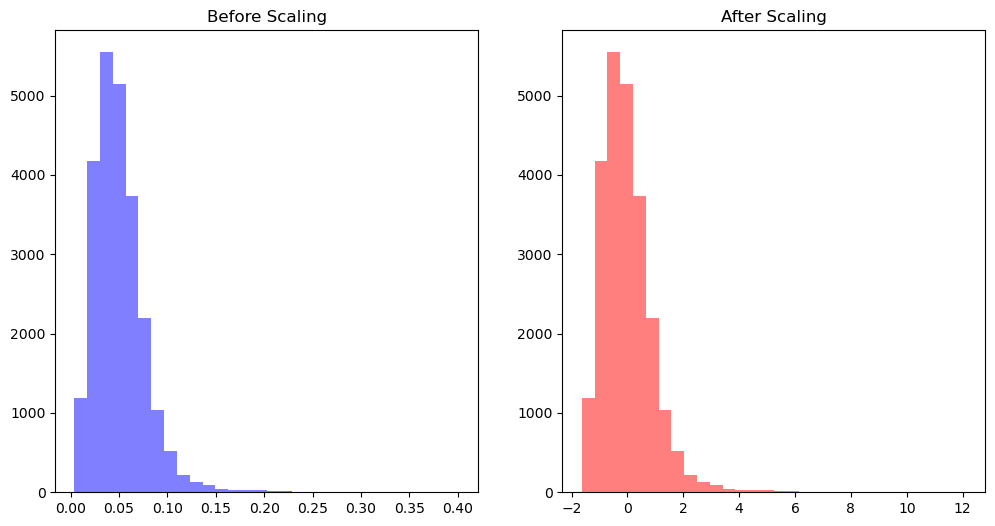

In [ ]:
# standardize statistical node features
from sklearn.preprocessing import StandardScaler

# Concatenate all x values before scaling for the first feature, as a sanity check for standardization
x_before = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

scaler = StandardScaler()
scaler.fit(np.vstack([data.x.numpy() for data in X_train + X_val])) # fit on training and validation data


# Transform the x values of the data in X_train
for data in X_train:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_val
for data in X_val:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_test
for data in X_test:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Concatenate all x values after scaling for the first feature, as a sanity check for standardization
x_after = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

# Plot the distribution of the first x feature before and after scaling as a sanity check
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_before, bins=30, color='b', alpha=0.5)
plt.title('Before Scaling')

plt.subplot(1, 2, 2)
plt.hist(x_after, bins=30, color='r', alpha=0.5)
plt.title('After Scaling')

plt.show()

### Model: standard GCN

In [42]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import RichProgressBar
import logging
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

def objective(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    batch_size = trial.suggest_categorical('batch_size', [170, 340, 510, 680, 850])
    dropout = trial.suggest_float('dropout', 0, 0.8)
    hyperparameters = dict(learning_rate=learning_rate, optimizer_name=optimizer_name, batch_size=batch_size dropout=dropout)
    print(f'Tested parameters: {hyperparameters}')
    n_epochs = batch_size * 4 # vary training epochs based on batch size

    # Create the model
    model = GCN(learning_rate=learning_rate, optimizer_name=optimizer_name dropout=dropout)

    

    # Create the PyTorch Lightning trainer
    trainer = Trainer(
        accelerator='gpu',
        devices=1,
        max_epochs=n_epochs,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_f1")],
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=True,
        enable_checkpointing=False
    )

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                              drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                            drop_last=True) # , num_workers=0, persistent_workers=True

    # Log the hyperparameters
    trainer.logger.log_hyperparams(hyperparameters)

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Evaluate the model
    val_f1 = trainer.callback_metrics["val_f1"].item()

    return val_f1

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.ThresholdPruner(lower=0.1, n_warmup_steps=100))
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

df = study.trials_dataframe()
df.to_pickle('eo_results_stand_GCN_trials.pkl')

[I 2024-05-22 23:31:20,792] A new study created in memory with name: no-name-350e6ebe-53bb-4416-aa46-97880d913655


Tested parameters: {'learning_rate': 1.1030076375935893e-05, 'optimizer_name': 'SGD', 'batch_size': 340, 'fc_layers': 2, 'dropout': 0.3491912294458883}


/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
[I 2024-05-22 23:32:58,489] Trial 0 pruned. Trial was pruned at epoch 512.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.008978026211240348, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.08424330692236125}


[I 2024-05-22 23:35:02,293] Trial 1 finished with value: 0.22673623263835907 and parameters: {'learning_rate': 0.008978026211240348, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.08424330692236125}. Best is trial 1 with value: 0.22673623263835907.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.03670116225036893, 'optimizer_name': 'SGD', 'batch_size': 680, 'fc_layers': 4, 'dropout': 0.6930715155609128}


[I 2024-05-22 23:35:14,709] Trial 2 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00011303610906490112, 'optimizer_name': 'SGD', 'batch_size': 680, 'fc_layers': 4, 'dropout': 0.5839000740100129}


[I 2024-05-22 23:35:46,887] Trial 3 pruned. Trial was pruned at epoch 267.


Tested parameters: {'learning_rate': 0.00017729489609689936, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 4, 'dropout': 0.6398796814551236}


[I 2024-05-22 23:36:01,927] Trial 4 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 1.3393601193482237e-05, 'optimizer_name': 'Adam', 'batch_size': 340, 'fc_layers': 4, 'dropout': 0.20969931119178195}


[I 2024-05-22 23:38:51,845] Trial 5 finished with value: 0.2153521180152893 and parameters: {'learning_rate': 1.3393601193482237e-05, 'optimizer': 'Adam', 'batch_size': 340, 'fc_layers': 4, 'dropout': 0.20969931119178195}. Best is trial 1 with value: 0.22673623263835907.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.036858373576934285, 'optimizer_name': 'Adam', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.6575394349084811}


[I 2024-05-22 23:39:23,957] Trial 6 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.04526951921809762, 'optimizer_name': 'Adam', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.5116330599241731}


[I 2024-05-22 23:39:36,919] Trial 7 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 2.2458358352005466e-05, 'optimizer_name': 'Adam', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.42152808590839164}


[I 2024-05-22 23:39:51,123] Trial 8 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.009435942875480498, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 3, 'dropout': 0.44119096894609167}


[I 2024-05-22 23:40:03,669] Trial 9 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0030257832212487105, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.06338611578494902}


[I 2024-05-22 23:40:19,036] Trial 10 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0010314952504859303, 'optimizer_name': 'Adam', 'batch_size': 340, 'fc_layers': 3, 'dropout': 0.09499510985957181}


[I 2024-05-22 23:40:39,684] Trial 11 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0034814468530024014, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.22609894572118636}


[I 2024-05-22 23:42:44,131] Trial 12 finished with value: 0.27235472202301025 and parameters: {'learning_rate': 0.0034814468530024014, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.22609894572118636}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.005422072407506699, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.2148213749038429}


[I 2024-05-22 23:44:47,533] Trial 13 finished with value: 0.24045148491859436 and parameters: {'learning_rate': 0.005422072407506699, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.2148213749038429}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.0012856252792730217, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.2394725653748156}


[I 2024-05-22 23:46:49,409] Trial 14 finished with value: 0.2212858498096466 and parameters: {'learning_rate': 0.0012856252792730217, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.2394725653748156}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.006223936641910956, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.22816279002199605}


[I 2024-05-22 23:48:52,820] Trial 15 finished with value: 0.23083943128585815 and parameters: {'learning_rate': 0.006223936641910956, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.22816279002199605}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.00035321919023667574, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.3237991881298424}


[I 2024-05-22 23:49:11,409] Trial 16 pruned. Trial was pruned at epoch 121.


Tested parameters: {'learning_rate': 0.09836398824733211, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.16219740197357432}


[I 2024-05-22 23:49:43,688] Trial 17 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.003193414297522416, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.7936774480152144}


[I 2024-05-22 23:49:59,386] Trial 18 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0006049732287448049, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.30715157191138237}


[I 2024-05-22 23:50:14,742] Trial 19 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0025112972002044585, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.015427130413068812}


[I 2024-05-22 23:50:30,408] Trial 20 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.009559933477181313, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.22441224745700966}


[I 2024-05-22 23:52:35,337] Trial 21 finished with value: 0.22039048373699188 and parameters: {'learning_rate': 0.009559933477181313, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.22441224745700966}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.005830996127413921, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.15567340631443508}


[I 2024-05-22 23:54:36,424] Trial 22 finished with value: 0.2223678082227707 and parameters: {'learning_rate': 0.005830996127413921, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.15567340631443508}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.016930330669292993, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.26890546613619193}


[I 2024-05-22 23:56:42,602] Trial 23 finished with value: 0.23299705982208252 and parameters: {'learning_rate': 0.016930330669292993, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.26890546613619193}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.018973227459375432, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.2981351222718556}


[I 2024-05-22 23:58:46,180] Trial 24 finished with value: 0.23988421261310577 and parameters: {'learning_rate': 0.018973227459375432, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.2981351222718556}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.02314422330440272, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.36978264437381764}


[I 2024-05-22 23:58:59,999] Trial 25 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0018237501809409092, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.15232249299326991}


[I 2024-05-23 00:03:03,027] Trial 26 finished with value: 0.25542497634887695 and parameters: {'learning_rate': 0.0018237501809409092, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.15232249299326991}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.0018678825033535172, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.14892013011031285}


[I 2024-05-23 00:07:07,003] Trial 27 finished with value: 0.2447860687971115 and parameters: {'learning_rate': 0.0018678825033535172, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.14892013011031285}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.001383608405053291, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.13598364539122465}


[I 2024-05-23 00:11:06,780] Trial 28 finished with value: 0.233134925365448 and parameters: {'learning_rate': 0.001383608405053291, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.13598364539122465}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.0005095171078496894, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.007646276300642796}


[I 2024-05-23 00:11:37,853] Trial 29 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00016866350488380904, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.13513511190653993}


[I 2024-05-23 00:15:46,741] Trial 30 finished with value: 0.23068355023860931 and parameters: {'learning_rate': 0.00016866350488380904, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.13513511190653993}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.0018242466292453172, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.17777632758304868}


[I 2024-05-23 00:19:48,482] Trial 31 finished with value: 0.24714526534080505 and parameters: {'learning_rate': 0.0018242466292453172, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.17777632758304868}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.0016604856867042878, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.07232213490248193}


[I 2024-05-23 00:23:46,421] Trial 32 finished with value: 0.2532512843608856 and parameters: {'learning_rate': 0.0016604856867042878, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.07232213490248193}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.000583915910386102, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.06829085354776296}


[I 2024-05-23 00:27:40,662] Trial 33 finished with value: 0.24358904361724854 and parameters: {'learning_rate': 0.000583915910386102, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.06829085354776296}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.0022049647213421516, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.09623565372245085}


[I 2024-05-23 00:31:44,537] Trial 34 finished with value: 0.24754565954208374 and parameters: {'learning_rate': 0.0022049647213421516, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.09623565372245085}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.003500702914737592, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.09596164027675018}


[I 2024-05-23 00:35:43,653] Trial 35 finished with value: 0.2507927417755127 and parameters: {'learning_rate': 0.003500702914737592, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.09596164027675018}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.0002721531842083016, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.037300394913937863}


[I 2024-05-23 00:39:46,770] Trial 36 finished with value: 0.2367056906223297 and parameters: {'learning_rate': 0.0002721531842083016, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.037300394913937863}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 6.385800635138956e-05, 'optimizer_name': 'SGD', 'batch_size': 340, 'fc_layers': 4, 'dropout': 0.0869138577632737}


[I 2024-05-23 00:42:28,566] Trial 37 finished with value: 0.1688176989555359 and parameters: {'learning_rate': 6.385800635138956e-05, 'optimizer': 'SGD', 'batch_size': 340, 'fc_layers': 4, 'dropout': 0.0869138577632737}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.004197403975878111, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.11503909661005522}


[I 2024-05-23 00:46:30,693] Trial 38 finished with value: 0.25966987013816833 and parameters: {'learning_rate': 0.004197403975878111, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.11503909661005522}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.004474472029396259, 'optimizer_name': 'Adam', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.26954036497221395}


[I 2024-05-23 00:47:01,274] Trial 39 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0007957095390430804, 'optimizer_name': 'SGD', 'batch_size': 680, 'fc_layers': 4, 'dropout': 0.4990033910463486}


[I 2024-05-23 00:47:14,162] Trial 40 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.012374202063045105, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.11575945282611386}


[I 2024-05-23 00:51:13,183] Trial 41 finished with value: 0.22253209352493286 and parameters: {'learning_rate': 0.012374202063045105, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.11575945282611386}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.0038518731655599464, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.18412158567569548}


[I 2024-05-23 00:55:16,875] Trial 42 finished with value: 0.2236035019159317 and parameters: {'learning_rate': 0.0038518731655599464, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.18412158567569548}. Best is trial 12 with value: 0.27235472202301025.


Tested parameters: {'learning_rate': 0.00117594168529437, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 4, 'dropout': 0.04776965902121802}


[I 2024-05-23 00:57:10,949] Trial 43 finished with value: 0.2862994372844696 and parameters: {'learning_rate': 0.00117594168529437, 'optimizer': 'SGD', 'batch_size': 850, 'fc_layers': 4, 'dropout': 0.04776965902121802}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.001043148128045364, 'optimizer_name': 'Adam', 'batch_size': 850, 'fc_layers': 4, 'dropout': 0.04711092566751571}


[I 2024-05-23 00:59:04,252] Trial 44 finished with value: 0.22859999537467957 and parameters: {'learning_rate': 0.001043148128045364, 'optimizer': 'Adam', 'batch_size': 850, 'fc_layers': 4, 'dropout': 0.04711092566751571}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.0017040221018269418, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 4, 'dropout': 0.03362324426216762}


[I 2024-05-23 01:00:56,782] Trial 45 finished with value: 0.24456284940242767 and parameters: {'learning_rate': 0.0017040221018269418, 'optimizer': 'SGD', 'batch_size': 850, 'fc_layers': 4, 'dropout': 0.03362324426216762}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.007587236489083262, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.1892694182487312}


[I 2024-05-23 01:02:51,078] Trial 46 finished with value: 0.2406453639268875 and parameters: {'learning_rate': 0.007587236489083262, 'optimizer': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.1892694182487312}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.000788080137928345, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'fc_layers': 4, 'dropout': 0.06056194275455855}


[I 2024-05-23 01:03:12,395] Trial 47 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0012466056084095593, 'optimizer_name': 'Adam', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.12676914245821153}


[I 2024-05-23 01:05:04,601] Trial 48 finished with value: 0.16043487191200256 and parameters: {'learning_rate': 0.0012466056084095593, 'optimizer': 'Adam', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.12676914245821153}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.0024003754289139757, 'optimizer_name': 'SGD', 'batch_size': 680, 'fc_layers': 3, 'dropout': 0.2537105243585162}


[I 2024-05-23 01:05:17,112] Trial 49 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.000367868217925221, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 4, 'dropout': 0.20303751717579951}


[I 2024-05-23 01:06:47,290] Trial 50 pruned. Trial was pruned at epoch 645.


Tested parameters: {'learning_rate': 0.0037212462118254254, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.09877545461116599}


[I 2024-05-23 01:10:49,547] Trial 51 finished with value: 0.22128142416477203 and parameters: {'learning_rate': 0.0037212462118254254, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.09877545461116599}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.004617350840023787, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.07705302232703785}


[I 2024-05-23 01:14:50,611] Trial 52 finished with value: 0.2194744050502777 and parameters: {'learning_rate': 0.004617350840023787, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.07705302232703785}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.0026822350913888954, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.015405503685616218}


[I 2024-05-23 01:18:53,925] Trial 53 finished with value: 0.19777357578277588 and parameters: {'learning_rate': 0.0026822350913888954, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.015405503685616218}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.007661899385567489, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.0028618024940963854}


[I 2024-05-23 01:22:58,876] Trial 54 finished with value: 0.19771647453308105 and parameters: {'learning_rate': 0.007661899385567489, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.0028618024940963854}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.011615118784330226, 'optimizer_name': 'SGD', 'batch_size': 340, 'fc_layers': 4, 'dropout': 0.11995755484755347}


[I 2024-05-23 01:25:34,578] Trial 55 finished with value: 0.23829352855682373 and parameters: {'learning_rate': 0.011615118784330226, 'optimizer': 'SGD', 'batch_size': 340, 'fc_layers': 4, 'dropout': 0.11995755484755347}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.0009267560818442596, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 4, 'dropout': 0.06200614777843786}


[I 2024-05-23 01:25:47,004] Trial 56 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0034943239916425312, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.16300042124682265}


[I 2024-05-23 01:29:52,054] Trial 57 finished with value: 0.2522481083869934 and parameters: {'learning_rate': 0.0034943239916425312, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.16300042124682265}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.001328301465974424, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.3582717351912782}


[I 2024-05-23 01:30:06,218] Trial 58 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0028054317726771564, 'optimizer_name': 'Adam', 'batch_size': 170, 'fc_layers': 2, 'dropout': 0.16132816312123904}


[I 2024-05-23 01:30:39,388] Trial 59 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.005668822125818908, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.21189348659617274}


[I 2024-05-23 01:34:41,429] Trial 60 finished with value: 0.24833235144615173 and parameters: {'learning_rate': 0.005668822125818908, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.21189348659617274}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.0018137870453101637, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.10995641030990186}


[I 2024-05-23 01:38:43,226] Trial 61 finished with value: 0.25054627656936646 and parameters: {'learning_rate': 0.0018137870453101637, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.10995641030990186}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.0031542315781957187, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.14711534909922552}


[I 2024-05-23 01:42:45,418] Trial 62 finished with value: 0.2709859609603882 and parameters: {'learning_rate': 0.0031542315781957187, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.14711534909922552}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.006293089547893477, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.16421372865848266}


[I 2024-05-23 01:46:44,779] Trial 63 finished with value: 0.24007955193519592 and parameters: {'learning_rate': 0.006293089547893477, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.16421372865848266}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.00158774256575421, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.23410159547053513}


[I 2024-05-23 01:50:50,529] Trial 64 finished with value: 0.21947839856147766 and parameters: {'learning_rate': 0.00158774256575421, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.23410159547053513}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.0024983274851343848, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.14635027648513993}


[I 2024-05-23 01:52:51,373] Trial 65 finished with value: 0.26458895206451416 and parameters: {'learning_rate': 0.0024983274851343848, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.14635027648513993}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.002217443968602659, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.6010721960163263}


[I 2024-05-23 01:53:06,965] Trial 66 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0004257012381110336, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.1306462754114593}


[I 2024-05-23 01:55:08,186] Trial 67 finished with value: 0.21954363584518433 and parameters: {'learning_rate': 0.0004257012381110336, 'optimizer': 'RMSprop', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.1306462754114593}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.0007529927684721522, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.19372801679487034}


[I 2024-05-23 01:57:11,956] Trial 68 finished with value: 0.23997576534748077 and parameters: {'learning_rate': 0.0007529927684721522, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.19372801679487034}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.0012339708708886258, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.7195910223193901}


[I 2024-05-23 01:57:27,482] Trial 69 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.000257025440691286, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.4669110631417918}


[I 2024-05-23 01:57:42,687] Trial 70 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0030361653156625187, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.1649381145382309}


[I 2024-05-23 02:01:42,894] Trial 71 finished with value: 0.251262903213501 and parameters: {'learning_rate': 0.0030361653156625187, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.1649381145382309}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.004587899672059737, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.1457836758602727}


[I 2024-05-23 02:05:40,818] Trial 72 finished with value: 0.21573230624198914 and parameters: {'learning_rate': 0.004587899672059737, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.1457836758602727}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.0022538125618873097, 'optimizer_name': 'SGD', 'batch_size': 340, 'fc_layers': 3, 'dropout': 0.04347483966704958}


[I 2024-05-23 02:08:25,724] Trial 73 finished with value: 0.241826131939888 and parameters: {'learning_rate': 0.0022538125618873097, 'optimizer': 'SGD', 'batch_size': 340, 'fc_layers': 3, 'dropout': 0.04347483966704958}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.0033836745198119905, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.27937240190684}


[I 2024-05-23 02:10:29,255] Trial 74 finished with value: 0.2562563419342041 and parameters: {'learning_rate': 0.0033836745198119905, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.27937240190684}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.009389148940299661, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.2986606224062597}


[I 2024-05-23 02:12:31,738] Trial 75 finished with value: 0.2188013643026352 and parameters: {'learning_rate': 0.009389148940299661, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.2986606224062597}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.0009702941771230694, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.2546919007292794}


[I 2024-05-23 02:12:46,792] Trial 76 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.004534044841227103, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.2860190200219851}


[I 2024-05-23 02:14:48,229] Trial 77 finished with value: 0.22255411744117737 and parameters: {'learning_rate': 0.004534044841227103, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.2860190200219851}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.0015630047424641, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.39010901057267233}


[I 2024-05-23 02:15:03,802] Trial 78 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 2.086936355759411e-05, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.08496519881058999}


[I 2024-05-23 02:16:58,485] Trial 79 finished with value: 0.17067191004753113 and parameters: {'learning_rate': 2.086936355759411e-05, 'optimizer': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.08496519881058999}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.006918616068827103, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.3232145525396359}


[I 2024-05-23 02:18:59,268] Trial 80 finished with value: 0.2052319496870041 and parameters: {'learning_rate': 0.006918616068827103, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.3232145525396359}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.003366637861768731, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.22483781818139476}


[I 2024-05-23 02:22:58,049] Trial 81 finished with value: 0.24499818682670593 and parameters: {'learning_rate': 0.003366637861768731, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.22483781818139476}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.0037703915656861933, 'optimizer_name': 'SGD', 'batch_size': 680, 'fc_layers': 3, 'dropout': 0.14174173385914246}


[I 2024-05-23 02:24:40,530] Trial 82 finished with value: 0.23379403352737427 and parameters: {'learning_rate': 0.0037703915656861933, 'optimizer': 'SGD', 'batch_size': 680, 'fc_layers': 3, 'dropout': 0.14174173385914246}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.002140970028168675, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.1913645256556142}


[I 2024-05-23 02:28:42,646] Trial 83 finished with value: 0.23566347360610962 and parameters: {'learning_rate': 0.002140970028168675, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.1913645256556142}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.002809255704636105, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.10740630044294053}


[I 2024-05-23 02:32:39,606] Trial 84 finished with value: 0.2304246723651886 and parameters: {'learning_rate': 0.002809255704636105, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.10740630044294053}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.012548121234270966, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.17762256186194372}


[I 2024-05-23 02:34:34,452] Trial 85 finished with value: 0.2421940118074417 and parameters: {'learning_rate': 0.012548121234270966, 'optimizer': 'SGD', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.17762256186194372}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.005045889241551546, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.025649046731944243}


[I 2024-05-23 02:34:49,652] Trial 86 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0005989244994926456, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.058964786642896415}


[I 2024-05-23 02:38:47,293] Trial 87 finished with value: 0.2313636839389801 and parameters: {'learning_rate': 0.0005989244994926456, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.058964786642896415}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.0011820728823776065, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.25274846588402955}


[I 2024-05-23 02:42:52,595] Trial 88 finished with value: 0.2415986955165863 and parameters: {'learning_rate': 0.0011820728823776065, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.25274846588402955}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.0018415595998115353, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.07506240987449056}


[I 2024-05-23 02:44:55,681] Trial 89 finished with value: 0.28624117374420166 and parameters: {'learning_rate': 0.0018415595998115353, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.07506240987449056}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.001977715250470505, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.07226847703710915}


[I 2024-05-23 02:46:59,472] Trial 90 finished with value: 0.24219897389411926 and parameters: {'learning_rate': 0.001977715250470505, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.07226847703710915}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.0031918711543811795, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.11489934882862819}


[I 2024-05-23 02:49:05,651] Trial 91 finished with value: 0.2418772280216217 and parameters: {'learning_rate': 0.0031918711543811795, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.11489934882862819}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.0015068638563482462, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.08768843382448595}


[I 2024-05-23 02:51:08,764] Trial 92 finished with value: 0.25774043798446655 and parameters: {'learning_rate': 0.0015068638563482462, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.08768843382448595}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.0014047432512214713, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.09088619775796694}


[I 2024-05-23 02:53:12,840] Trial 93 finished with value: 0.2501872777938843 and parameters: {'learning_rate': 0.0014047432512214713, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.09088619775796694}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.001755143923326893, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.04355195451008528}


[I 2024-05-23 02:55:18,047] Trial 94 finished with value: 0.20753303170204163 and parameters: {'learning_rate': 0.001755143923326893, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.04355195451008528}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.000736091606399733, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.13461591902334755}


[I 2024-05-23 02:57:20,849] Trial 95 finished with value: 0.2046993225812912 and parameters: {'learning_rate': 0.000736091606399733, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.13461591902334755}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.002438057435425495, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.07682514582158928}


[I 2024-05-23 02:57:36,544] Trial 96 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0015271332252863674, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.023776582613469988}


[I 2024-05-23 02:59:42,038] Trial 97 finished with value: 0.22148002684116364 and parameters: {'learning_rate': 0.0015271332252863674, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.023776582613469988}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.0010206660942002218, 'optimizer_name': 'SGD', 'batch_size': 340, 'fc_layers': 4, 'dropout': 0.20951385890824548}


[I 2024-05-23 03:02:19,168] Trial 98 finished with value: 0.24402426183223724 and parameters: {'learning_rate': 0.0010206660942002218, 'optimizer': 'SGD', 'batch_size': 340, 'fc_layers': 4, 'dropout': 0.20951385890824548}. Best is trial 43 with value: 0.2862994372844696.


Tested parameters: {'learning_rate': 0.00404395790336724, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 4, 'dropout': 0.10210961619704975}


[I 2024-05-23 03:04:12,543] Trial 99 finished with value: 0.21765030920505524 and parameters: {'learning_rate': 0.00404395790336724, 'optimizer': 'SGD', 'batch_size': 850, 'fc_layers': 4, 'dropout': 0.10210961619704975}. Best is trial 43 with value: 0.2862994372844696.


Best trial:
  Value: 0.2862994372844696
  Params: 
    learning_rate: 0.00117594168529437
    optimizer: SGD
    batch_size: 850
    fc_layers: 4
    dropout: 0.04776965902121802


In [43]:
df_trials = pd.read_pickle('eo_results_stand_GCN_trials.pkl')
df_trials.sort_values('value', ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
43      43  0.286299 2024-05-23 00:55:16.878320 2024-05-23 00:57:10.948110   
89      89  0.286241 2024-05-23 02:42:52.596669 2024-05-23 02:44:55.679856   
12      12  0.272355 2024-05-22 23:40:39.686177 2024-05-22 23:42:44.129774   
62      62  0.270986 2024-05-23 01:38:43.228861 2024-05-23 01:42:45.417666   
65      65  0.264589 2024-05-23 01:50:50.532321 2024-05-23 01:52:51.372629   
38      38  0.259670 2024-05-23 00:42:28.568901 2024-05-23 00:46:30.692182   
92      92  0.257740 2024-05-23 02:49:05.652743 2024-05-23 02:51:08.763443   
74      74  0.256256 2024-05-23 02:08:25.725772 2024-05-23 02:10:29.254584   
26      26  0.255425 2024-05-22 23:59:00.001712 2024-05-23 00:03:03.026601   
32      32  0.253251 2024-05-23 00:19:48.485208 2024-05-23 00:23:46.419901   

                 duration  params_batch_size  params_dropout  \
43 0 days 00:01:54.069790                850        0.047770   
89 0 days 00:02:03.083187                510        0.075062   
12 0 days 00:02:04.443597                510        0.226099   
62 0 days 00:04:02.188805                170        0.147115   
65 0 days 00:02:00.840308                510        0.146350   
38 0 days 00:04:02.123281                170        0.115039   
92 0 days 00:02:03.110700                510        0.087688   
74 0 days 00:02:03.528812                510        0.279372   
26 0 days 00:04:03.024889                170        0.152322   
32 0 days 00:03:57.934693                170        0.072322   

    params_fc_layers  params_learning_rate params_optimizer     state  
43                 4              0.001176              SGD  COMPLETE  
89                 4              0.001842              SGD  COMPLETE  
12                 3              0.003481              SGD  COMPLETE  
62                 3              0.003154              SGD  COMPLETE  
65                 3              0.002498              SGD  COMPLETE  
38                 4              0.004197              SGD  COMPLETE  
92                 4              0.001507              SGD  COMPLETE  
74                 3              0.003384              SGD  COMPLETE  
26                 3              0.001824              SGD  COMPLETE  
32                 3              0.001660              SGD  COMPLETE

#### Visualizations

/tmp/ipykernel_41868/1755039964.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

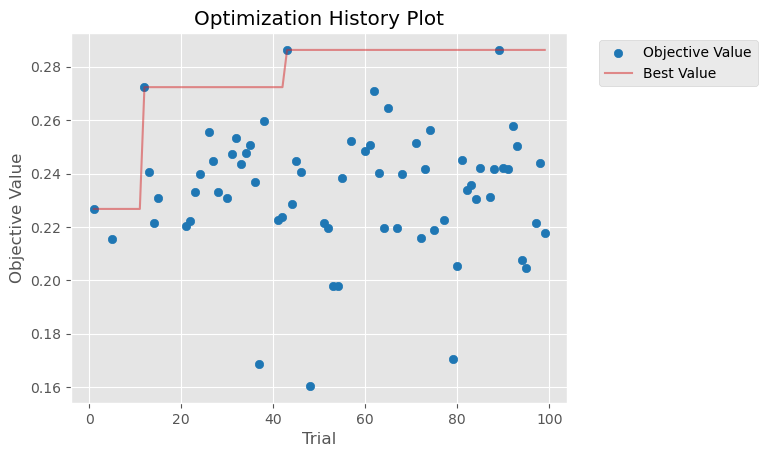

In [44]:
# Visualize the optimization history
plot_optimization_history(study)

[I 2024-05-23 03:04:12,896] A new study created in memory with name: no-name-38e6e642-f62e-415d-b92a-b8db04241932
/tmp/ipykernel_41868/1240065685.py:7: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  plot_intermediate_values(plotted_study)


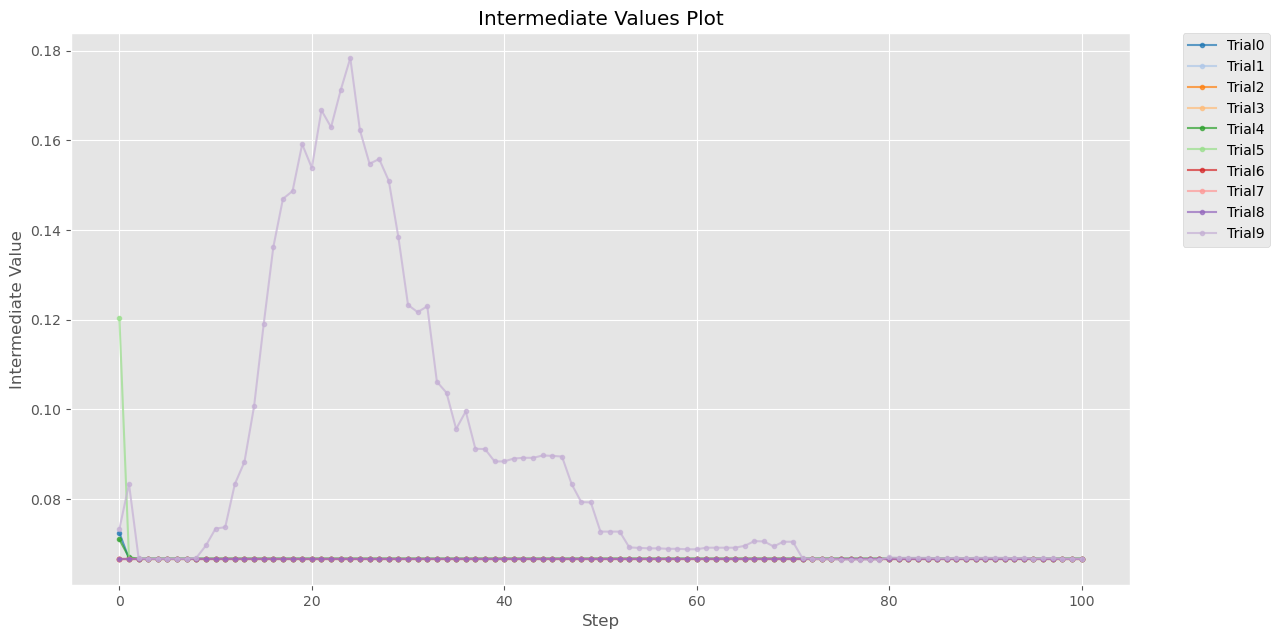

In [45]:
# Visualize the learning curves of the best 10 trials
trials = study.trials
plotted_trials = sorted(trials, key=lambda t: t.value, reverse=True)[:10]
plotted_study = optuna.create_study()
for trial in plotted_trials:
    plotted_study.add_trial(trial)
plot_intermediate_values(plotted_study)
set_size(10, 5)

/tmp/ipykernel_41868/2919792376.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


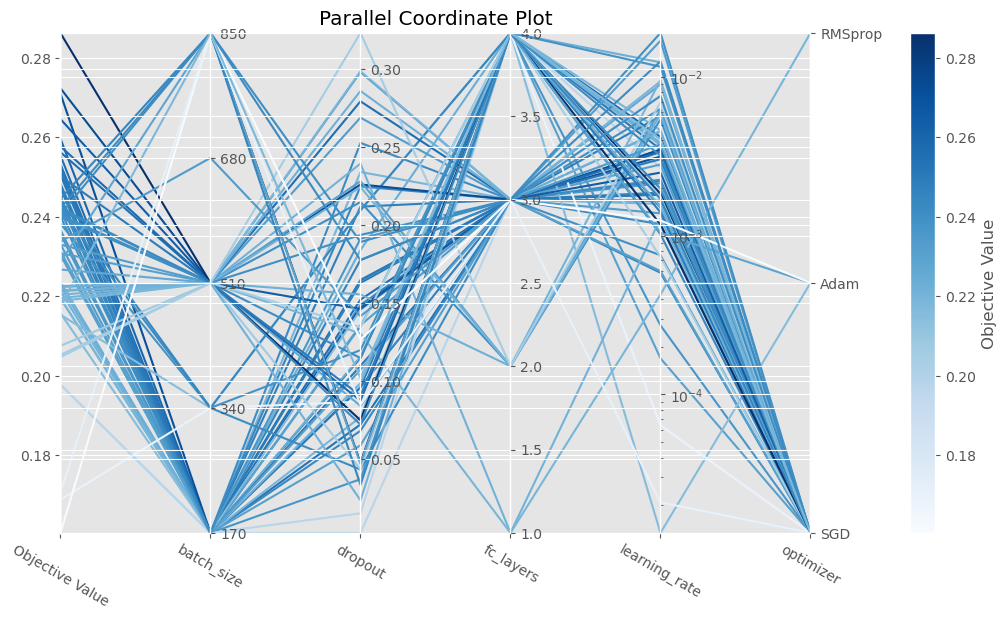

In [46]:
# Visualize high-dimensional parameter relationships.
plot_parallel_coordinate(study)
set_size(10, 5)

/tmp/ipykernel_41868/624402143.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2024-05-23 03:04:14,073] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


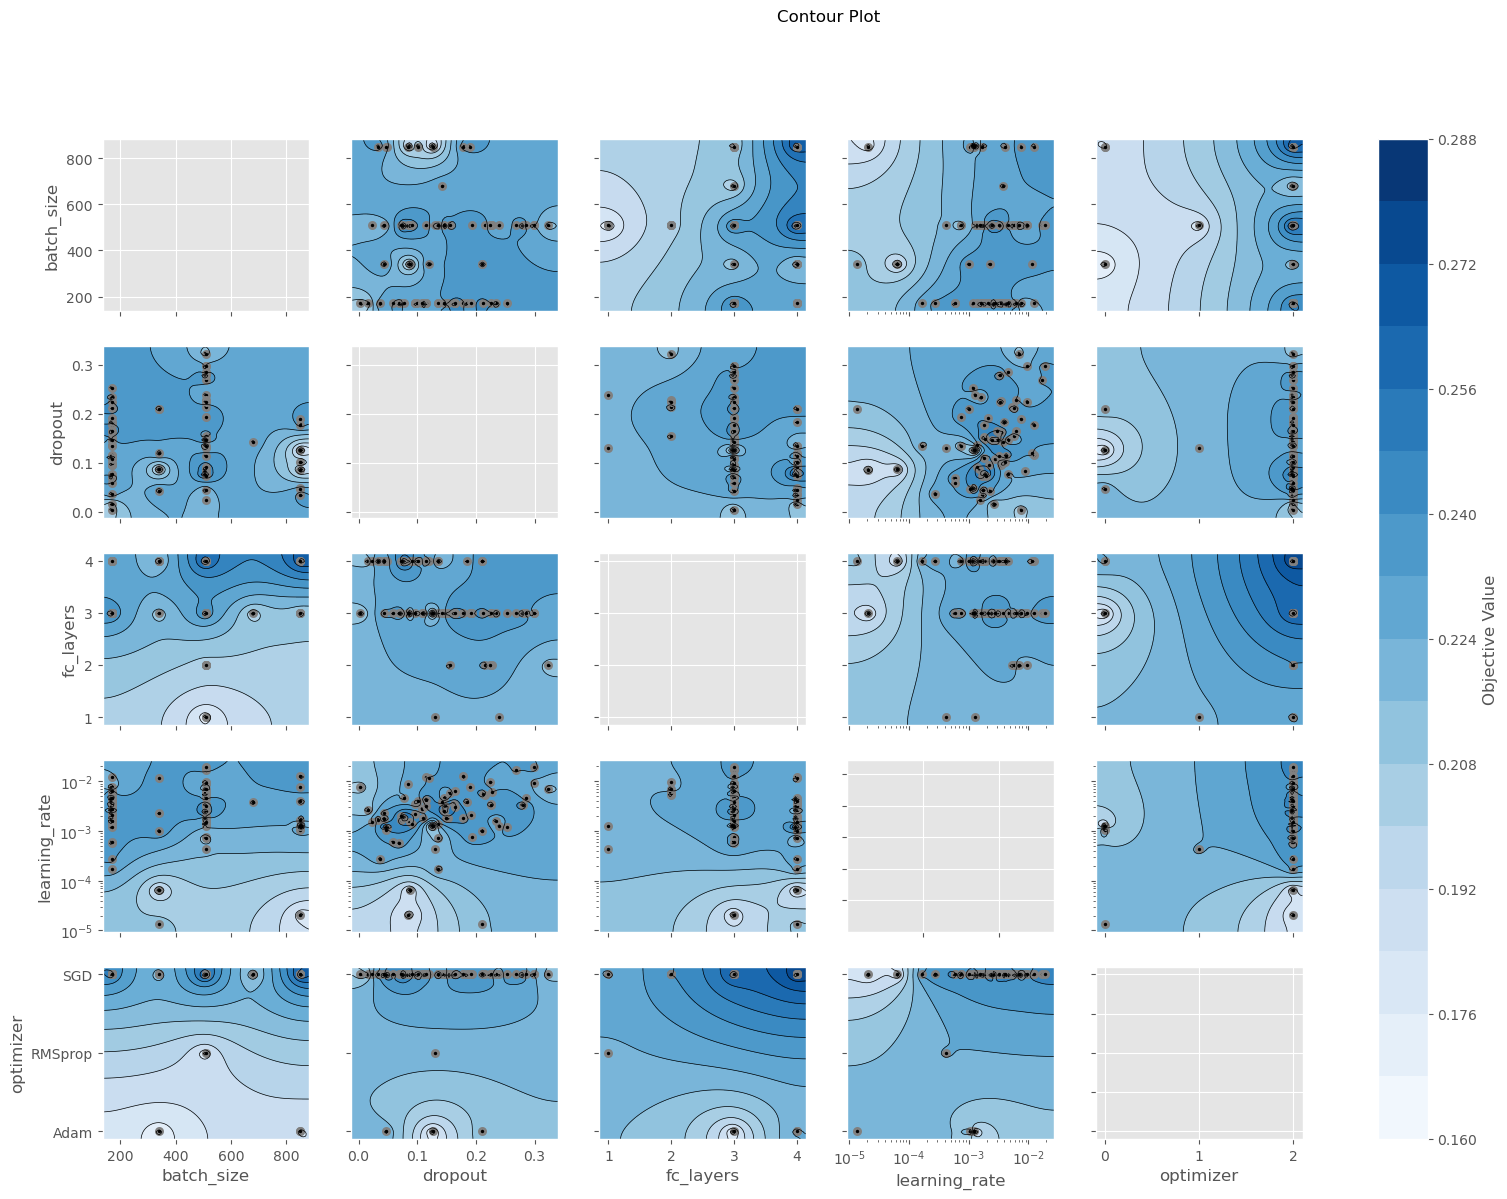

In [47]:
# Visualize hyperparameter relationships
plot_contour(study)
set_size(15, 10)

/tmp/ipykernel_41868/1888575690.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<Axes: xlabel='batch_size', ylabel='Objective Value'>,
       <Axes: xlabel='dropout'>, <Axes: xlabel='fc_layers'>,
       <Axes: xlabel='learning_rate'>, <Axes: xlabel='optimizer'>],
      dtype=object)

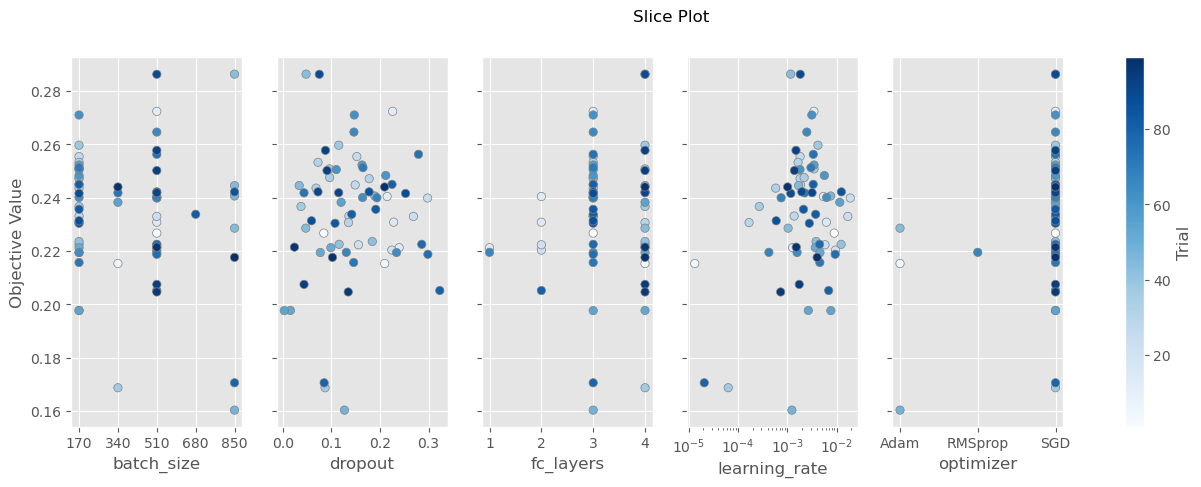

In [48]:
# Visualize individual hyperparameters as slice plot
plot_slice(study)

/tmp/ipykernel_41868/1473508994.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

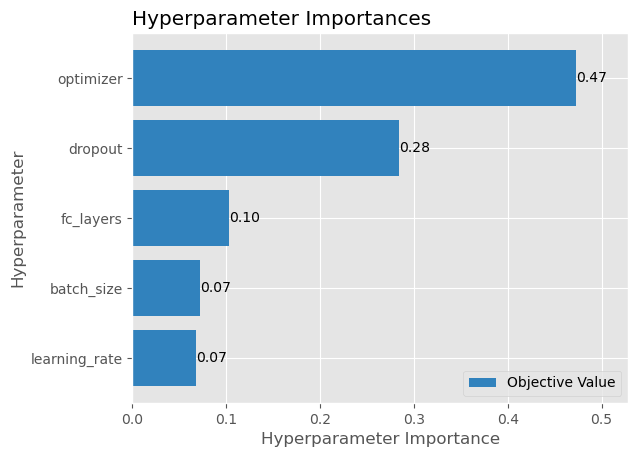

In [49]:
# Visualize parameter importances.
plot_param_importances(study)

/tmp/ipykernel_41868/3113371256.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

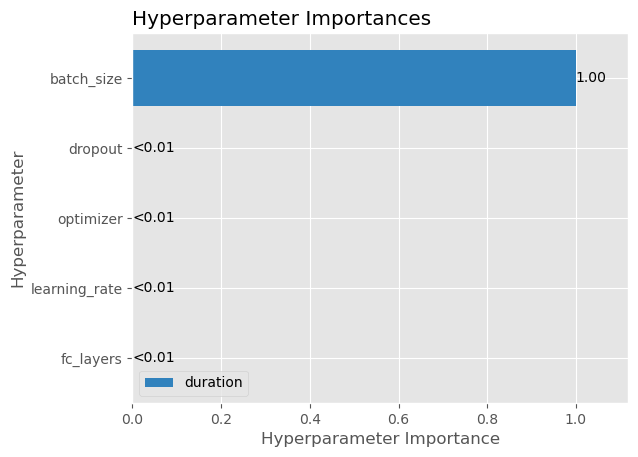

In [50]:
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

/tmp/ipykernel_41868/1828777839.py:2: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  plot_edf(study)


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

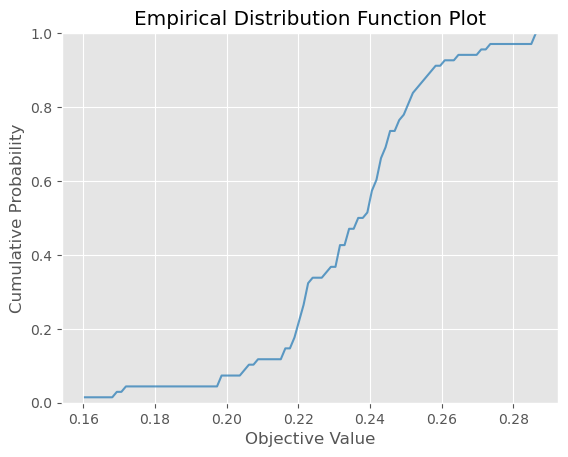

In [51]:
# Visualize empirical distribution function.
plot_edf(study)

/tmp/ipykernel_41868/1172520691.py:2: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  plot_rank(study)
[W 2024-05-23 03:04:22,415] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


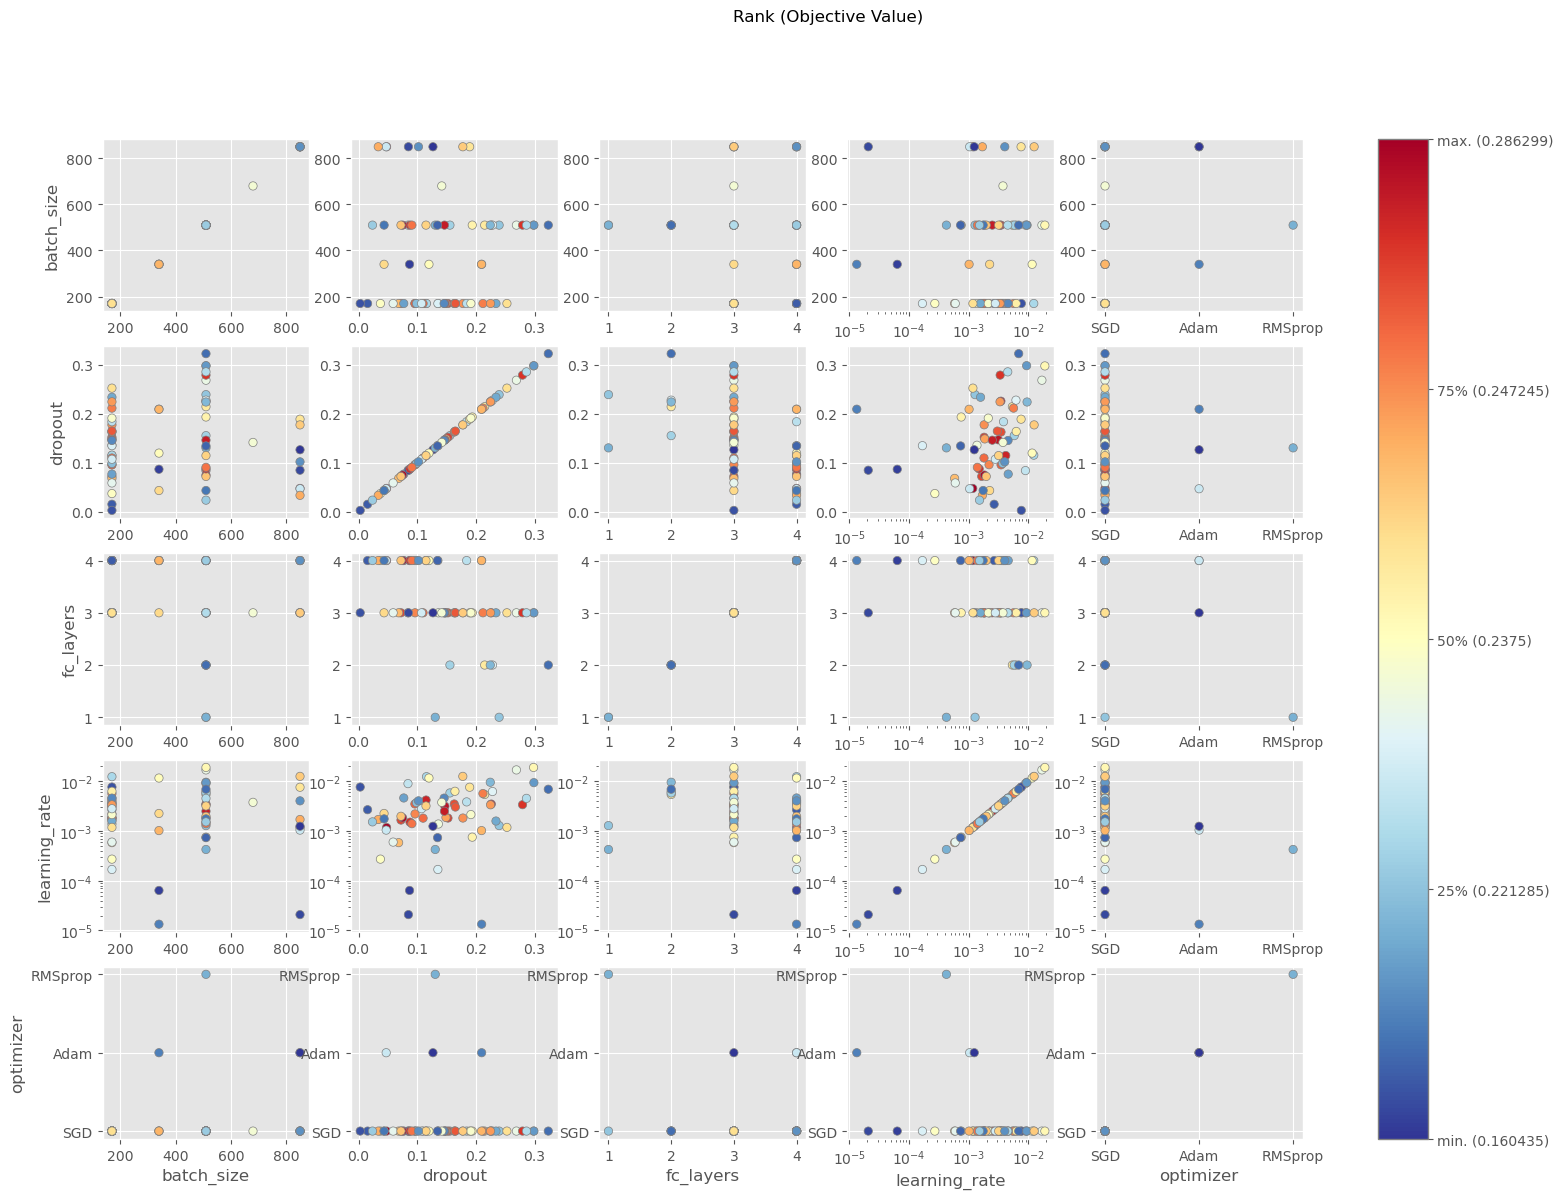

In [52]:
# Visualize parameter relations with scatter plots colored by objective values.
plot_rank(study)
set_size(15, 10)

/tmp/ipykernel_41868/124343896.py:2: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  plot_timeline(study)


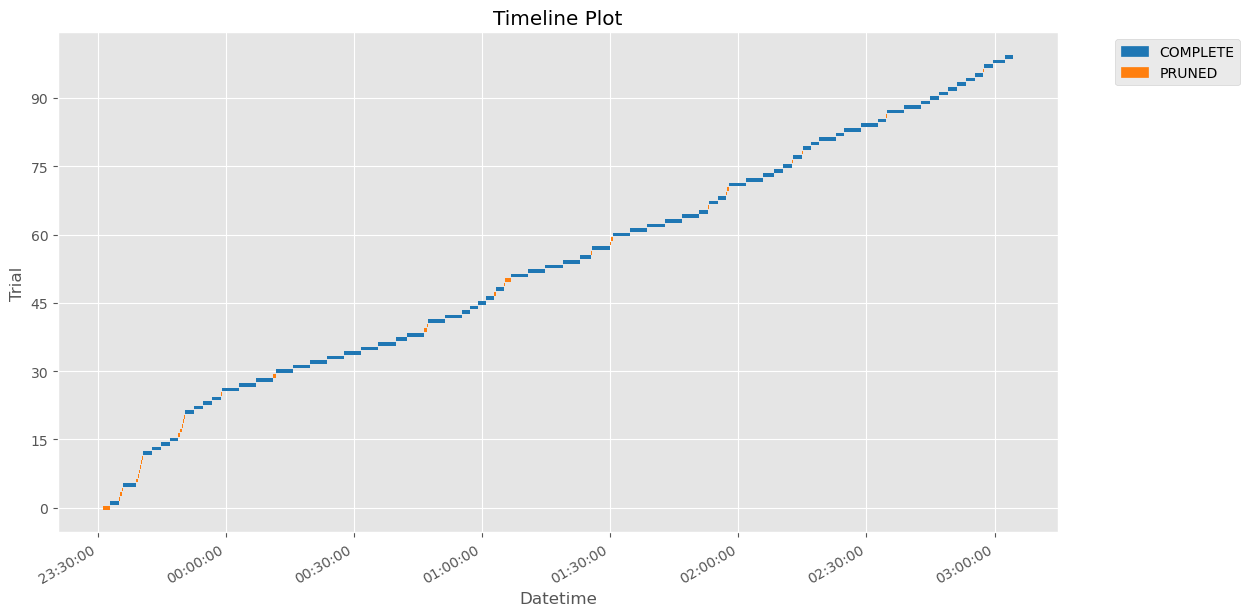

In [53]:
# Visualize the optimization timeline of performed trials.
plot_timeline(study)
set_size(10, 5)

# 3. ratio feature set

In [66]:
from sklearn.model_selection import StratifiedGroupKFold

baseline_rest_idxs = data_split_indices['ratio'][0]
baseline_val_idxs = data_split_indices['ratio'][1]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_ratio_ids for i in range(12)] # times 12 for each epoch

print(f'{len(ratio_graph_dataset) = }')
print(f'{len(baseline_rest_idxs) = }, {len(baseline_val_idxs) = }, total: {len(baseline_rest_idxs)+len(baseline_val_idxs)}')

X_traintest = [ratio_graph_dataset[i] for i in baseline_rest_idxs] 
X_val = [ratio_graph_dataset[i] for i in baseline_val_idxs]
Y_traintest =[ratio_y_list[i] for i in baseline_rest_idxs]
Y_val = [ratio_y_list[i] for i in baseline_val_idxs]
groups_traintest = [groups[i] for i in baseline_rest_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]

# now splitting the test and training data with seperate StratifiedGroupKFold
desired_test_ratio = 0.20
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)  # should shuffle be true?

train_idxs, test_idxs = sgkf.split(X_traintest, Y_traintest, groups_traintest).__next__() # just take the first split
print(f'{len(X_traintest) = }, {len(X_val) = }')
print(f'{len(train_idxs) = }, {len(test_idxs) = }, total: {len(train_idxs)+len(test_idxs)}')

X_train = [X_traintest[i] for i in train_idxs] # X also includes y values, because they are stored in the Data object
X_test = [X_traintest[i] for i in test_idxs]
Y_train =[Y_traintest[i] for i in train_idxs]
Y_test = [Y_traintest[i] for i in test_idxs]

len(ratio_graph_dataset) = 2688
len(baseline_rest_idxs) = 2148, len(baseline_val_idxs) = 540, total: 2688
len(X_traintest) = 2148, len(X_val) = 540
len(train_idxs) = 1716, len(test_idxs) = 432, total: 2148


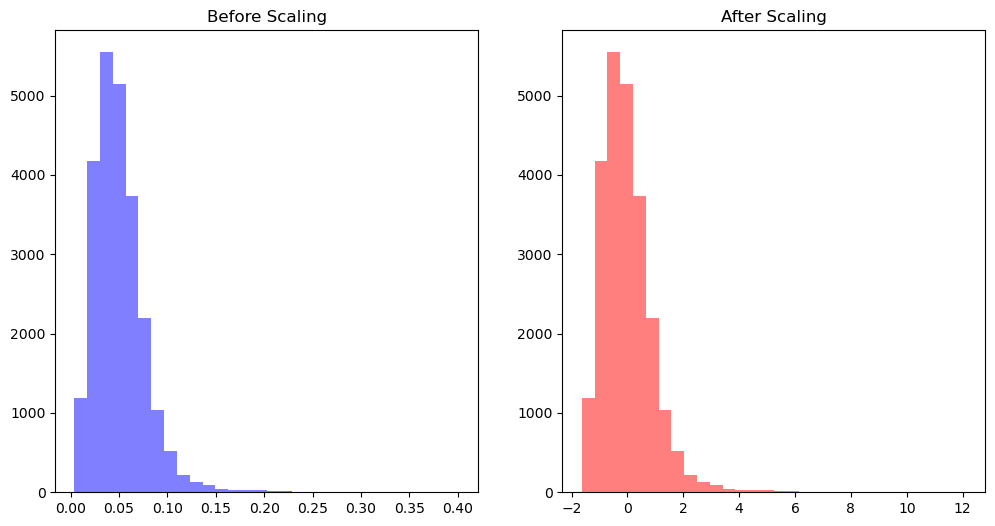

In [ ]:
# standardize statistical node features
from sklearn.preprocessing import StandardScaler

# Concatenate all x values before scaling for the first feature, as a sanity check for standardization
x_before = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

scaler = StandardScaler()
scaler.fit(np.vstack([data.x.numpy() for data in X_train + X_val])) # fit on training and validation data


# Transform the x values of the data in X_train
for data in X_train:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_val
for data in X_val:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_test
for data in X_test:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Concatenate all x values after scaling for the first feature, as a sanity check for standardization
x_after = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

# Plot the distribution of the first x feature before and after scaling as a sanity check
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_before, bins=30, color='b', alpha=0.5)
plt.title('Before Scaling')

plt.subplot(1, 2, 2)
plt.hist(x_after, bins=30, color='r', alpha=0.5)
plt.title('After Scaling')

plt.show()

### Model: standard GCN

In [67]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import RichProgressBar
import logging
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

def objective(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    batch_size = trial.suggest_categorical('batch_size', [170, 340, 510, 680, 850])
    dropout = trial.suggest_float('dropout', 0, 0.8)
    hyperparameters = dict(learning_rate=learning_rate, optimizer_name=optimizer_name, batch_size=batch_size dropout=dropout)
    print(f'Tested parameters: {hyperparameters}')
    n_epochs = batch_size * 4 # vary training epochs based on batch size

    # Create the model
    model = GCN(learning_rate=learning_rate, optimizer_name=optimizer_name dropout=dropout)

    

    # Create the PyTorch Lightning trainer
    trainer = Trainer(
        accelerator='gpu',
        devices=1,
        max_epochs=n_epochs,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_f1")],
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=True,
        enable_checkpointing=False
    )

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                              drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                            drop_last=True) # , num_workers=0, persistent_workers=True

    # Log the hyperparameters
    trainer.logger.log_hyperparams(hyperparameters)

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Evaluate the model
    val_f1 = trainer.callback_metrics["val_f1"].item()

    return val_f1

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.ThresholdPruner(lower=0.1, n_warmup_steps=100))
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

df = study.trials_dataframe()
df.to_pickle('ratio_results_stand_GCN_trials.pkl')

[I 2024-05-23 07:21:39,647] A new study created in memory with name: no-name-c834fa5a-d910-4f73-8d1e-4fb9ceca2d8e


Tested parameters: {'learning_rate': 7.041984080776753e-05, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'fc_layers': 3, 'dropout': 0.6755408578691691}


/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
[I 2024-05-23 07:22:11,892] Trial 0 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.06364397549917854, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.16476666439983723}


[I 2024-05-23 07:26:19,145] Trial 1 finished with value: 0.2070467174053192 and parameters: {'learning_rate': 0.06364397549917854, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.16476666439983723}. Best is trial 1 with value: 0.2070467174053192.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.005711682540947832, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'fc_layers': 3, 'dropout': 0.36029572375450913}


[I 2024-05-23 07:26:39,301] Trial 2 pruned. Trial was pruned at epoch 100.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.0015868545249295449, 'optimizer_name': 'Adam', 'batch_size': 850, 'fc_layers': 1, 'dropout': 0.5729007243911822}


[I 2024-05-23 07:28:33,232] Trial 3 finished with value: 0.15786346793174744 and parameters: {'learning_rate': 0.0015868545249295449, 'optimizer': 'Adam', 'batch_size': 850, 'fc_layers': 1, 'dropout': 0.5729007243911822}. Best is trial 1 with value: 0.2070467174053192.


Tested parameters: {'learning_rate': 0.0012652122569157005, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.7216521017200783}


[I 2024-05-23 07:29:04,510] Trial 4 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0905089367473065, 'optimizer_name': 'Adam', 'batch_size': 680, 'fc_layers': 4, 'dropout': 0.3413821165124543}


[I 2024-05-23 07:29:17,816] Trial 5 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.06653056431150588, 'optimizer_name': 'Adam', 'batch_size': 850, 'fc_layers': 3, 'dropout': 0.36447551990526056}


[I 2024-05-23 07:29:32,240] Trial 6 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0021459390302922994, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'fc_layers': 3, 'dropout': 0.7876163539122575}


[I 2024-05-23 07:29:52,703] Trial 7 pruned. Trial was pruned at epoch 100.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.001084487876014097, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.004606087905200074}


[I 2024-05-23 07:30:08,922] Trial 8 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.01736514189835994, 'optimizer_name': 'SGD', 'batch_size': 340, 'fc_layers': 3, 'dropout': 0.5776950026010838}


[I 2024-05-23 07:30:29,266] Trial 9 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 4.813047018392138e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.08375126798393306}


[I 2024-05-23 07:31:00,489] Trial 10 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00021554395563250177, 'optimizer_name': 'Adam', 'batch_size': 850, 'fc_layers': 1, 'dropout': 0.16136972860522691}


[I 2024-05-23 07:32:52,180] Trial 11 finished with value: 0.19140249490737915 and parameters: {'learning_rate': 0.00021554395563250177, 'optimizer': 'Adam', 'batch_size': 850, 'fc_layers': 1, 'dropout': 0.16136972860522691}. Best is trial 1 with value: 0.2070467174053192.


Tested parameters: {'learning_rate': 0.00020001392660274456, 'optimizer_name': 'SGD', 'batch_size': 850, 'fc_layers': 2, 'dropout': 0.19008593100463386}


[I 2024-05-23 07:33:49,666] Trial 12 pruned. Trial was pruned at epoch 413.


Tested parameters: {'learning_rate': 0.00021346139100608178, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.22407568107660172}


[I 2024-05-23 07:35:52,071] Trial 13 finished with value: 0.19772420823574066 and parameters: {'learning_rate': 0.00021346139100608178, 'optimizer': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.22407568107660172}. Best is trial 1 with value: 0.2070467174053192.


Tested parameters: {'learning_rate': 1.1117227122364156e-05, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.23914456992322214}


[I 2024-05-23 07:37:54,258] Trial 14 finished with value: 0.14730143547058105 and parameters: {'learning_rate': 1.1117227122364156e-05, 'optimizer': 'SGD', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.23914456992322214}. Best is trial 1 with value: 0.2070467174053192.


Tested parameters: {'learning_rate': 0.00026887302489446733, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.24904363344620042}


[I 2024-05-23 07:39:57,876] Trial 15 finished with value: 0.2228422462940216 and parameters: {'learning_rate': 0.00026887302489446733, 'optimizer': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.24904363344620042}. Best is trial 15 with value: 0.2228422462940216.


Tested parameters: {'learning_rate': 0.008365590422006883, 'optimizer_name': 'SGD', 'batch_size': 680, 'fc_layers': 4, 'dropout': 0.4801045128152698}


[I 2024-05-23 07:40:11,335] Trial 16 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.027948655810726385, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 2, 'dropout': 0.27103400700607294}


[I 2024-05-23 07:40:45,051] Trial 17 pruned. Trial was pruned at epoch 107.


Tested parameters: {'learning_rate': 0.00043158597504243623, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.11208176971008377}


[I 2024-05-23 07:41:01,128] Trial 18 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.004769129216938172, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.444635580044901}


[I 2024-05-23 07:41:16,903] Trial 19 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 4.0597041030681e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.05595590223793326}


[I 2024-05-23 07:41:46,156] Trial 20 pruned. Trial was pruned at epoch 102.


Tested parameters: {'learning_rate': 0.00037873065952029664, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.26002797929574156}


[I 2024-05-23 07:43:49,602] Trial 21 finished with value: 0.2134404480457306 and parameters: {'learning_rate': 0.00037873065952029664, 'optimizer': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.26002797929574156}. Best is trial 15 with value: 0.2228422462940216.


Tested parameters: {'learning_rate': 0.0004945278200717186, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.287175110692701}


[I 2024-05-23 07:45:54,593] Trial 22 finished with value: 0.16636855900287628 and parameters: {'learning_rate': 0.0004945278200717186, 'optimizer': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.287175110692701}. Best is trial 15 with value: 0.2228422462940216.


Tested parameters: {'learning_rate': 0.00047200187136444853, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.14668147252583918}


[I 2024-05-23 07:47:59,813] Trial 23 finished with value: 0.22434204816818237 and parameters: {'learning_rate': 0.00047200187136444853, 'optimizer': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.14668147252583918}. Best is trial 23 with value: 0.22434204816818237.


Tested parameters: {'learning_rate': 0.0004637468734689864, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.2829226922737397}


[I 2024-05-23 07:50:09,044] Trial 24 finished with value: 0.18491992354393005 and parameters: {'learning_rate': 0.0004637468734689864, 'optimizer': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.2829226922737397}. Best is trial 23 with value: 0.22434204816818237.


Tested parameters: {'learning_rate': 0.00011924336827630498, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.13586981966947223}


[I 2024-05-23 07:52:11,648] Trial 25 finished with value: 0.20680466294288635 and parameters: {'learning_rate': 0.00011924336827630498, 'optimizer': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.13586981966947223}. Best is trial 23 with value: 0.22434204816818237.


Tested parameters: {'learning_rate': 0.0005871770252764023, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.014463697766590039}


[I 2024-05-23 07:54:16,159] Trial 26 finished with value: 0.21065302193164825 and parameters: {'learning_rate': 0.0005871770252764023, 'optimizer': 'Adam', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.014463697766590039}. Best is trial 23 with value: 0.22434204816818237.


Tested parameters: {'learning_rate': 2.3147250768038205e-05, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.4357351940656071}


[I 2024-05-23 07:54:31,980] Trial 27 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.002859576392993775, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.20863616268527335}


[I 2024-05-23 07:54:47,182] Trial 28 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 8.574480452742626e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.33556621617907456}


[I 2024-05-23 07:56:29,417] Trial 29 finished with value: 0.2386961430311203 and parameters: {'learning_rate': 8.574480452742626e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.33556621617907456}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 9.476112323384072e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.3216523173275824}


[I 2024-05-23 07:58:10,049] Trial 30 finished with value: 0.22379286587238312 and parameters: {'learning_rate': 9.476112323384072e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.3216523173275824}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 0.00011790138653544782, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.32634602695932446}


[I 2024-05-23 07:59:50,979] Trial 31 finished with value: 0.21421551704406738 and parameters: {'learning_rate': 0.00011790138653544782, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.32634602695932446}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 8.896796459583058e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.5070394651425311}


[I 2024-05-23 08:01:31,078] Trial 32 finished with value: 0.21608662605285645 and parameters: {'learning_rate': 8.896796459583058e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.5070394651425311}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 2.5955347487045568e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.392091516079837}


[I 2024-05-23 08:03:13,802] Trial 33 finished with value: 0.1694885641336441 and parameters: {'learning_rate': 2.5955347487045568e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.392091516079837}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 6.025513598690674e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.3136279115551911}


[I 2024-05-23 08:04:54,145] Trial 34 finished with value: 0.22577068209648132 and parameters: {'learning_rate': 6.025513598690674e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.3136279115551911}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 6.212704301680297e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.30980473376977596}


[I 2024-05-23 08:06:36,346] Trial 35 finished with value: 0.2117241472005844 and parameters: {'learning_rate': 6.212704301680297e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.30980473376977596}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 1.645375578186197e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.5598911998742513}


[I 2024-05-23 08:08:14,286] Trial 36 finished with value: 0.1410401165485382 and parameters: {'learning_rate': 1.645375578186197e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.5598911998742513}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 0.00013440548266733458, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.39108982531771874}


[I 2024-05-23 08:09:59,087] Trial 37 finished with value: 0.2025061547756195 and parameters: {'learning_rate': 0.00013440548266733458, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.39108982531771874}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 3.6209068120502096e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.33755309793782073}


[I 2024-05-23 08:11:41,908] Trial 38 finished with value: 0.21916505694389343 and parameters: {'learning_rate': 3.6209068120502096e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.33755309793782073}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 0.0008473618216133858, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.4305107090450399}


[I 2024-05-23 08:11:54,755] Trial 39 pruned. Trial was pruned at epoch 103.


Tested parameters: {'learning_rate': 7.116751641307016e-05, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'fc_layers': 1, 'dropout': 0.18729047019887135}


[I 2024-05-23 08:14:35,540] Trial 40 finished with value: 0.20593206584453583 and parameters: {'learning_rate': 7.116751641307016e-05, 'optimizer': 'RMSprop', 'batch_size': 340, 'fc_layers': 1, 'dropout': 0.18729047019887135}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 0.0002919166631993244, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 3, 'dropout': 0.1448539706731023}


[I 2024-05-23 08:14:48,111] Trial 41 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00015675724893457395, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.3492358689686023}


[I 2024-05-23 08:16:27,459] Trial 42 finished with value: 0.20132507383823395 and parameters: {'learning_rate': 0.00015675724893457395, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.3492358689686023}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 0.000797525664976842, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.23623830872116086}


[I 2024-05-23 08:18:07,366] Trial 43 finished with value: 0.2092992663383484 and parameters: {'learning_rate': 0.000797525664976842, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.23623830872116086}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 0.00029308593952370786, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'fc_layers': 3, 'dropout': 0.29998130192362743}


[I 2024-05-23 08:18:27,031] Trial 44 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 8.217340162284836e-05, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'fc_layers': 2, 'dropout': 0.3611952559570427}


[I 2024-05-23 08:18:41,320] Trial 45 pruned. Trial was pruned at epoch 101.


Tested parameters: {'learning_rate': 0.0019766369701952995, 'optimizer_name': 'Adam', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.09249417490921724}


[I 2024-05-23 08:20:19,252] Trial 46 finished with value: 0.19389787316322327 and parameters: {'learning_rate': 0.0019766369701952995, 'optimizer': 'Adam', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.09249417490921724}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 5.650226205867864e-05, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'fc_layers': 2, 'dropout': 0.1797700506197011}


[I 2024-05-23 08:22:11,967] Trial 47 finished with value: 0.1887749433517456 and parameters: {'learning_rate': 5.650226205867864e-05, 'optimizer': 'RMSprop', 'batch_size': 850, 'fc_layers': 2, 'dropout': 0.1797700506197011}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 0.00026171477922770306, 'optimizer_name': 'Adam', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.2545648776275541}


[I 2024-05-23 08:26:12,265] Trial 48 finished with value: 0.2142173945903778 and parameters: {'learning_rate': 0.00026171477922770306, 'optimizer': 'Adam', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.2545648776275541}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 3.0508119298585716e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 3, 'dropout': 0.3826294245407444}


[I 2024-05-23 08:26:24,970] Trial 49 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00018036099617405925, 'optimizer_name': 'Adam', 'batch_size': 680, 'fc_layers': 2, 'dropout': 0.21310660203900192}


[I 2024-05-23 08:28:08,507] Trial 50 finished with value: 0.19005617499351501 and parameters: {'learning_rate': 0.00018036099617405925, 'optimizer': 'Adam', 'batch_size': 680, 'fc_layers': 2, 'dropout': 0.21310660203900192}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 3.9059450918148964e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.32537040515090154}


[I 2024-05-23 08:29:47,254] Trial 51 finished with value: 0.21686497330665588 and parameters: {'learning_rate': 3.9059450918148964e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.32537040515090154}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 1.4408552526747215e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.3349497779742709}


[I 2024-05-23 08:30:07,625] Trial 52 pruned. Trial was pruned at epoch 157.


Tested parameters: {'learning_rate': 9.542212158088811e-05, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'fc_layers': 1, 'dropout': 0.4712788391992889}


[I 2024-05-23 08:30:28,207] Trial 53 pruned. Trial was pruned at epoch 106.


Tested parameters: {'learning_rate': 3.83070112150025e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.41855928647678065}


[I 2024-05-23 08:32:06,631] Trial 54 finished with value: 0.19146791100502014 and parameters: {'learning_rate': 3.83070112150025e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.41855928647678065}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 1.854582615715919e-05, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.364846855091868}


[I 2024-05-23 08:34:07,580] Trial 55 finished with value: 0.18136009573936462 and parameters: {'learning_rate': 1.854582615715919e-05, 'optimizer': 'RMSprop', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.364846855091868}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 0.0013933181516100678, 'optimizer_name': 'SGD', 'batch_size': 680, 'fc_layers': 2, 'dropout': 0.2899648103325068}


[I 2024-05-23 08:34:20,484] Trial 56 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 1.013794472077899e-05, 'optimizer_name': 'Adam', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.2664079814802053}


[I 2024-05-23 08:38:18,535] Trial 57 finished with value: 0.2104557901620865 and parameters: {'learning_rate': 1.013794472077899e-05, 'optimizer': 'Adam', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.2664079814802053}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 5.70862544877324e-05, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.6434607156845442}


[I 2024-05-23 08:38:34,178] Trial 58 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00010214872837394781, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'fc_layers': 1, 'dropout': 0.23725151792693017}


[I 2024-05-23 08:40:25,833] Trial 59 finished with value: 0.18352091312408447 and parameters: {'learning_rate': 0.00010214872837394781, 'optimizer': 'RMSprop', 'batch_size': 850, 'fc_layers': 1, 'dropout': 0.23725151792693017}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 0.0001714503169232986, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.15567329346661962}


[I 2024-05-23 08:42:31,152] Trial 60 finished with value: 0.1836358904838562 and parameters: {'learning_rate': 0.0001714503169232986, 'optimizer': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.15567329346661962}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 3.80729587256669e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.3206112193570688}


[I 2024-05-23 08:42:44,816] Trial 61 pruned. Trial was pruned at epoch 110.


Tested parameters: {'learning_rate': 4.591754373690398e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.2971270481920645}


[I 2024-05-23 08:44:25,726] Trial 62 finished with value: 0.21797655522823334 and parameters: {'learning_rate': 4.591754373690398e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.2971270481920645}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 5.0341503141345486e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.30007153947948517}


[I 2024-05-23 08:46:04,582] Trial 63 finished with value: 0.1970083862543106 and parameters: {'learning_rate': 5.0341503141345486e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.30007153947948517}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 2.844145854270167e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.35537184075556943}


[I 2024-05-23 08:47:46,871] Trial 64 finished with value: 0.20247569680213928 and parameters: {'learning_rate': 2.844145854270167e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.35537184075556943}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 0.00034166777529451726, 'optimizer_name': 'SGD', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.2638249598074074}


[I 2024-05-23 08:49:27,025] Trial 65 finished with value: 0.19625774025917053 and parameters: {'learning_rate': 0.00034166777529451726, 'optimizer': 'SGD', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.2638249598074074}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 7.900277764365716e-05, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.2061012625546782}


[I 2024-05-23 08:51:29,299] Trial 66 finished with value: 0.2249440848827362 and parameters: {'learning_rate': 7.900277764365716e-05, 'optimizer': 'RMSprop', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.2061012625546782}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 0.00022500308556781587, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'fc_layers': 4, 'dropout': 0.042201498310981564}


[I 2024-05-23 08:51:44,937] Trial 67 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0006586946048477879, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.20455941183953052}


[I 2024-05-23 08:52:15,200] Trial 68 pruned. Trial was pruned at epoch 195.


Tested parameters: {'learning_rate': 7.680944205700355e-05, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.16832254572732241}


[I 2024-05-23 08:54:18,468] Trial 69 finished with value: 0.2139405757188797 and parameters: {'learning_rate': 7.680944205700355e-05, 'optimizer': 'RMSprop', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.16832254572732241}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 0.0001495135420934568, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.12137166088564838}


[I 2024-05-23 08:56:21,629] Trial 70 finished with value: 0.21457529067993164 and parameters: {'learning_rate': 0.0001495135420934568, 'optimizer': 'Adam', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.12137166088564838}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 2.1703813149995223e-05, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.2496991369847614}


[I 2024-05-23 08:58:24,524] Trial 71 finished with value: 0.17416737973690033 and parameters: {'learning_rate': 2.1703813149995223e-05, 'optimizer': 'RMSprop', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.2496991369847614}. Best is trial 29 with value: 0.2386961430311203.


Tested parameters: {'learning_rate': 0.00011439063725679033, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.2802738548270952}


[I 2024-05-23 09:00:02,130] Trial 72 finished with value: 0.24077439308166504 and parameters: {'learning_rate': 0.00011439063725679033, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.2802738548270952}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 0.00011975827109108956, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.2245041540389543}


[I 2024-05-23 09:01:42,846] Trial 73 finished with value: 0.22371052205562592 and parameters: {'learning_rate': 0.00011975827109108956, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.2245041540389543}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 0.0001117300167371282, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.20013173892753022}


[I 2024-05-23 09:03:45,812] Trial 74 finished with value: 0.17670725286006927 and parameters: {'learning_rate': 0.0001117300167371282, 'optimizer': 'RMSprop', 'batch_size': 510, 'fc_layers': 1, 'dropout': 0.20013173892753022}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 0.00021488535063267418, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.22509894528296123}


[I 2024-05-23 09:07:42,718] Trial 75 finished with value: 0.20036782324314117 and parameters: {'learning_rate': 0.00021488535063267418, 'optimizer': 'RMSprop', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.22509894528296123}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 0.00013744552502763447, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'fc_layers': 1, 'dropout': 0.09687785585121199}


[I 2024-05-23 09:10:16,665] Trial 76 finished with value: 0.1974739134311676 and parameters: {'learning_rate': 0.00013744552502763447, 'optimizer': 'RMSprop', 'batch_size': 340, 'fc_layers': 1, 'dropout': 0.09687785585121199}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 7.123768418223734e-05, 'optimizer_name': 'SGD', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.27940499344022973}


[I 2024-05-23 09:11:57,734] Trial 77 finished with value: 0.17840620875358582 and parameters: {'learning_rate': 7.123768418223734e-05, 'optimizer': 'SGD', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.27940499344022973}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 0.00037797079543606916, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.14073578310614396}


[I 2024-05-23 09:13:37,318] Trial 78 finished with value: 0.2125653624534607 and parameters: {'learning_rate': 0.00037797079543606916, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.14073578310614396}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 9.078277406090985e-05, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.06594752233387158}


[I 2024-05-23 09:15:41,901] Trial 79 finished with value: 0.20422567427158356 and parameters: {'learning_rate': 9.078277406090985e-05, 'optimizer': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.06594752233387158}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 0.00046628361859917916, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'fc_layers': 1, 'dropout': 0.18249060944974838}


[I 2024-05-23 09:17:30,667] Trial 80 finished with value: 0.1938306987285614 and parameters: {'learning_rate': 0.00046628361859917916, 'optimizer': 'RMSprop', 'batch_size': 850, 'fc_layers': 1, 'dropout': 0.18249060944974838}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 6.380899859090247e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.3763630272636092}


[I 2024-05-23 09:19:08,699] Trial 81 finished with value: 0.23404699563980103 and parameters: {'learning_rate': 6.380899859090247e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.3763630272636092}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 0.00011655420693788363, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.7863478496173232}


[I 2024-05-23 09:19:21,935] Trial 82 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0002533367054703117, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.4102707597773554}


[I 2024-05-23 09:21:00,736] Trial 83 finished with value: 0.21825453639030457 and parameters: {'learning_rate': 0.0002533367054703117, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.4102707597773554}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 6.697222970112696e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.37461539399471666}


[I 2024-05-23 09:22:40,739] Trial 84 finished with value: 0.19353115558624268 and parameters: {'learning_rate': 6.697222970112696e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.37461539399471666}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 0.00017743889839287152, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.3140410308680476}


[I 2024-05-23 09:24:21,641] Trial 85 finished with value: 0.17512176930904388 and parameters: {'learning_rate': 0.00017743889839287152, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.3140410308680476}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 0.0010466717564477667, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.4533420114050557}


[I 2024-05-23 09:24:33,866] Trial 86 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00012667181628733893, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 2, 'dropout': 0.34545332861636036}


[I 2024-05-23 09:24:49,548] Trial 87 pruned. Trial was pruned at epoch 102.


Tested parameters: {'learning_rate': 0.03206702817752398, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.23050561770102412}


[I 2024-05-23 09:25:02,215] Trial 88 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0006080896751529255, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.39454665454875426}


[I 2024-05-23 09:26:40,844] Trial 89 finished with value: 0.17911919951438904 and parameters: {'learning_rate': 0.0006080896751529255, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.39454665454875426}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 5.249179533444386e-05, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'fc_layers': 1, 'dropout': 0.2768060156950527}


[I 2024-05-23 09:29:21,047] Trial 90 finished with value: 0.18014869093894958 and parameters: {'learning_rate': 5.249179533444386e-05, 'optimizer': 'RMSprop', 'batch_size': 340, 'fc_layers': 1, 'dropout': 0.2768060156950527}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 3.471068678245619e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.33648878916432606}


[I 2024-05-23 09:31:03,716] Trial 91 finished with value: 0.19239488244056702 and parameters: {'learning_rate': 3.471068678245619e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.33648878916432606}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 8.620746698645512e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.3737017361746565}


[I 2024-05-23 09:32:46,302] Trial 92 finished with value: 0.20757636427879333 and parameters: {'learning_rate': 8.620746698645512e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.3737017361746565}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 6.084203786496345e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.24861541540948928}


[I 2024-05-23 09:34:25,718] Trial 93 finished with value: 0.22400306165218353 and parameters: {'learning_rate': 6.084203786496345e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.24861541540948928}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 6.352228483892528e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.2493706401872846}


[I 2024-05-23 09:36:03,730] Trial 94 finished with value: 0.20795264840126038 and parameters: {'learning_rate': 6.352228483892528e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.2493706401872846}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 0.00010108767514813872, 'optimizer_name': 'Adam', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.22021293358192517}


[I 2024-05-23 09:37:44,442] Trial 95 finished with value: 0.18589720129966736 and parameters: {'learning_rate': 0.00010108767514813872, 'optimizer': 'Adam', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.22021293358192517}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 0.00014449009269271418, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.1629087051988287}


[I 2024-05-23 09:41:46,044] Trial 96 finished with value: 0.21829640865325928 and parameters: {'learning_rate': 0.00014449009269271418, 'optimizer': 'RMSprop', 'batch_size': 170, 'fc_layers': 1, 'dropout': 0.1629087051988287}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 7.62892369691473e-05, 'optimizer_name': 'SGD', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.3162319006869528}


[I 2024-05-23 09:42:02,317] Trial 97 pruned. Trial was pruned at epoch 102.


Tested parameters: {'learning_rate': 5.544034067545257e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.27991744805644353}


[I 2024-05-23 09:43:44,553] Trial 98 finished with value: 0.18510350584983826 and parameters: {'learning_rate': 5.544034067545257e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 1, 'dropout': 0.27991744805644353}. Best is trial 72 with value: 0.24077439308166504.


Tested parameters: {'learning_rate': 4.351454292625271e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 2, 'dropout': 0.19532672147670657}


[I 2024-05-23 09:45:27,399] Trial 99 finished with value: 0.20713180303573608 and parameters: {'learning_rate': 4.351454292625271e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 2, 'dropout': 0.19532672147670657}. Best is trial 72 with value: 0.24077439308166504.


Best trial:
  Value: 0.24077439308166504
  Params: 
    learning_rate: 0.00011439063725679033
    optimizer: RMSprop
    batch_size: 680
    fc_layers: 1
    dropout: 0.2802738548270952


In [68]:
df_trials = pd.read_pickle('ratio_results_stand_GCN_trials.pkl')
df_trials.sort_values('value', ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
72      72  0.240774 2024-05-23 08:58:24.526077 2024-05-23 09:00:02.129110   
29      29  0.238696 2024-05-23 07:54:47.183915 2024-05-23 07:56:29.416631   
81      81  0.234047 2024-05-23 09:17:30.668911 2024-05-23 09:19:08.698280   
34      34  0.225771 2024-05-23 08:03:13.805185 2024-05-23 08:04:54.144644   
66      66  0.224944 2024-05-23 08:49:27.026967 2024-05-23 08:51:29.296088   
23      23  0.224342 2024-05-23 07:45:54.596350 2024-05-23 07:47:59.812097   
93      93  0.224003 2024-05-23 09:32:46.305695 2024-05-23 09:34:25.716900   
30      30  0.223793 2024-05-23 07:56:29.420082 2024-05-23 07:58:10.047686   
73      73  0.223711 2024-05-23 09:00:02.133612 2024-05-23 09:01:42.844990   
15      15  0.222842 2024-05-23 07:37:54.259744 2024-05-23 07:39:57.875524   

                 duration  params_batch_size  params_dropout  \
72 0 days 00:01:37.603033                680        0.280274   
29 0 days 00:01:42.232716                680        0.335566   
81 0 days 00:01:38.029369                680        0.376363   
34 0 days 00:01:40.339459                680        0.313628   
66 0 days 00:02:02.269121                510        0.206101   
23 0 days 00:02:05.215747                510        0.146681   
93 0 days 00:01:39.411205                680        0.248615   
30 0 days 00:01:40.627604                680        0.321652   
73 0 days 00:01:40.711378                680        0.224504   
15 0 days 00:02:03.615780                510        0.249044   

    params_fc_layers  params_learning_rate params_optimizer     state  
72                 1              0.000114          RMSprop  COMPLETE  
29                 1              0.000086          RMSprop  COMPLETE  
81                 1              0.000064          RMSprop  COMPLETE  
34                 1              0.000060          RMSprop  COMPLETE  
66                 1              0.000079          RMSprop  COMPLETE  
23                 2              0.000472             Adam  COMPLETE  
93                 1              0.000061          RMSprop  COMPLETE  
30                 1              0.000095          RMSprop  COMPLETE  
73                 1              0.000120          RMSprop  COMPLETE  
15                 2              0.000269             Adam  COMPLETE

#### Visualizations

/tmp/ipykernel_41868/1755039964.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

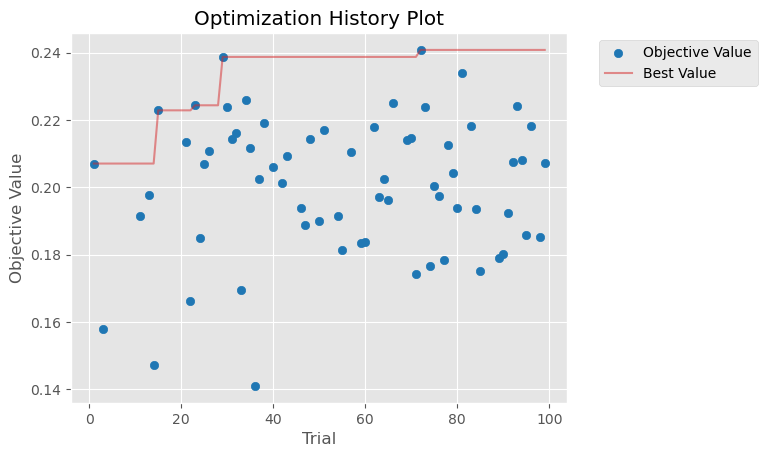

In [69]:
# Visualize the optimization history
plot_optimization_history(study)

[I 2024-05-23 09:45:27,742] A new study created in memory with name: no-name-0b813311-1b36-4662-9bf4-77d3aaad4a80
/tmp/ipykernel_41868/1240065685.py:7: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  plot_intermediate_values(plotted_study)


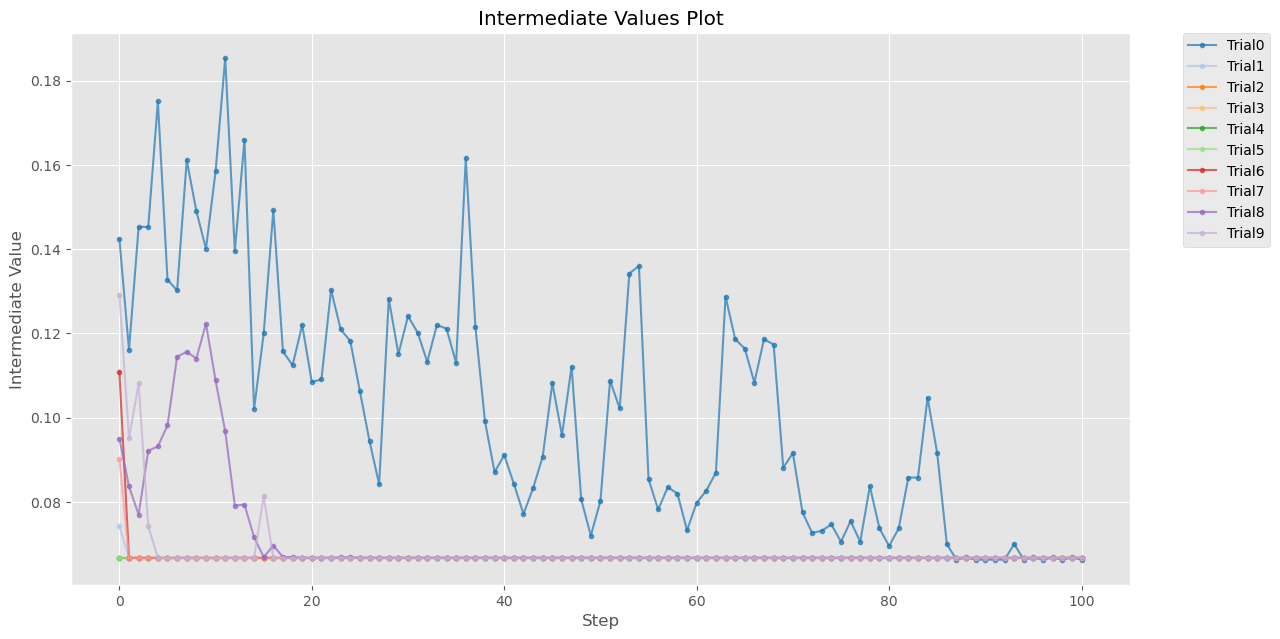

In [70]:
# Visualize the learning curves of the best 10 trials
trials = study.trials
plotted_trials = sorted(trials, key=lambda t: t.value, reverse=True)[:10]
plotted_study = optuna.create_study()
for trial in plotted_trials:
    plotted_study.add_trial(trial)
plot_intermediate_values(plotted_study)
set_size(10, 5)

/tmp/ipykernel_41868/2919792376.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


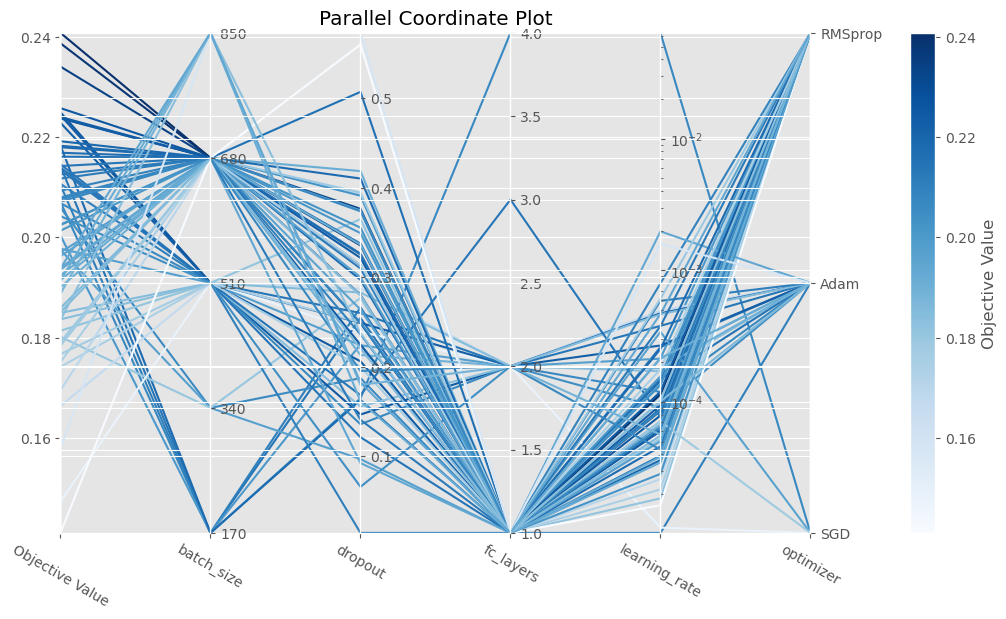

In [71]:
# Visualize high-dimensional parameter relationships.
plot_parallel_coordinate(study)
set_size(10, 5)

/tmp/ipykernel_41868/624402143.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2024-05-23 09:45:28,901] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


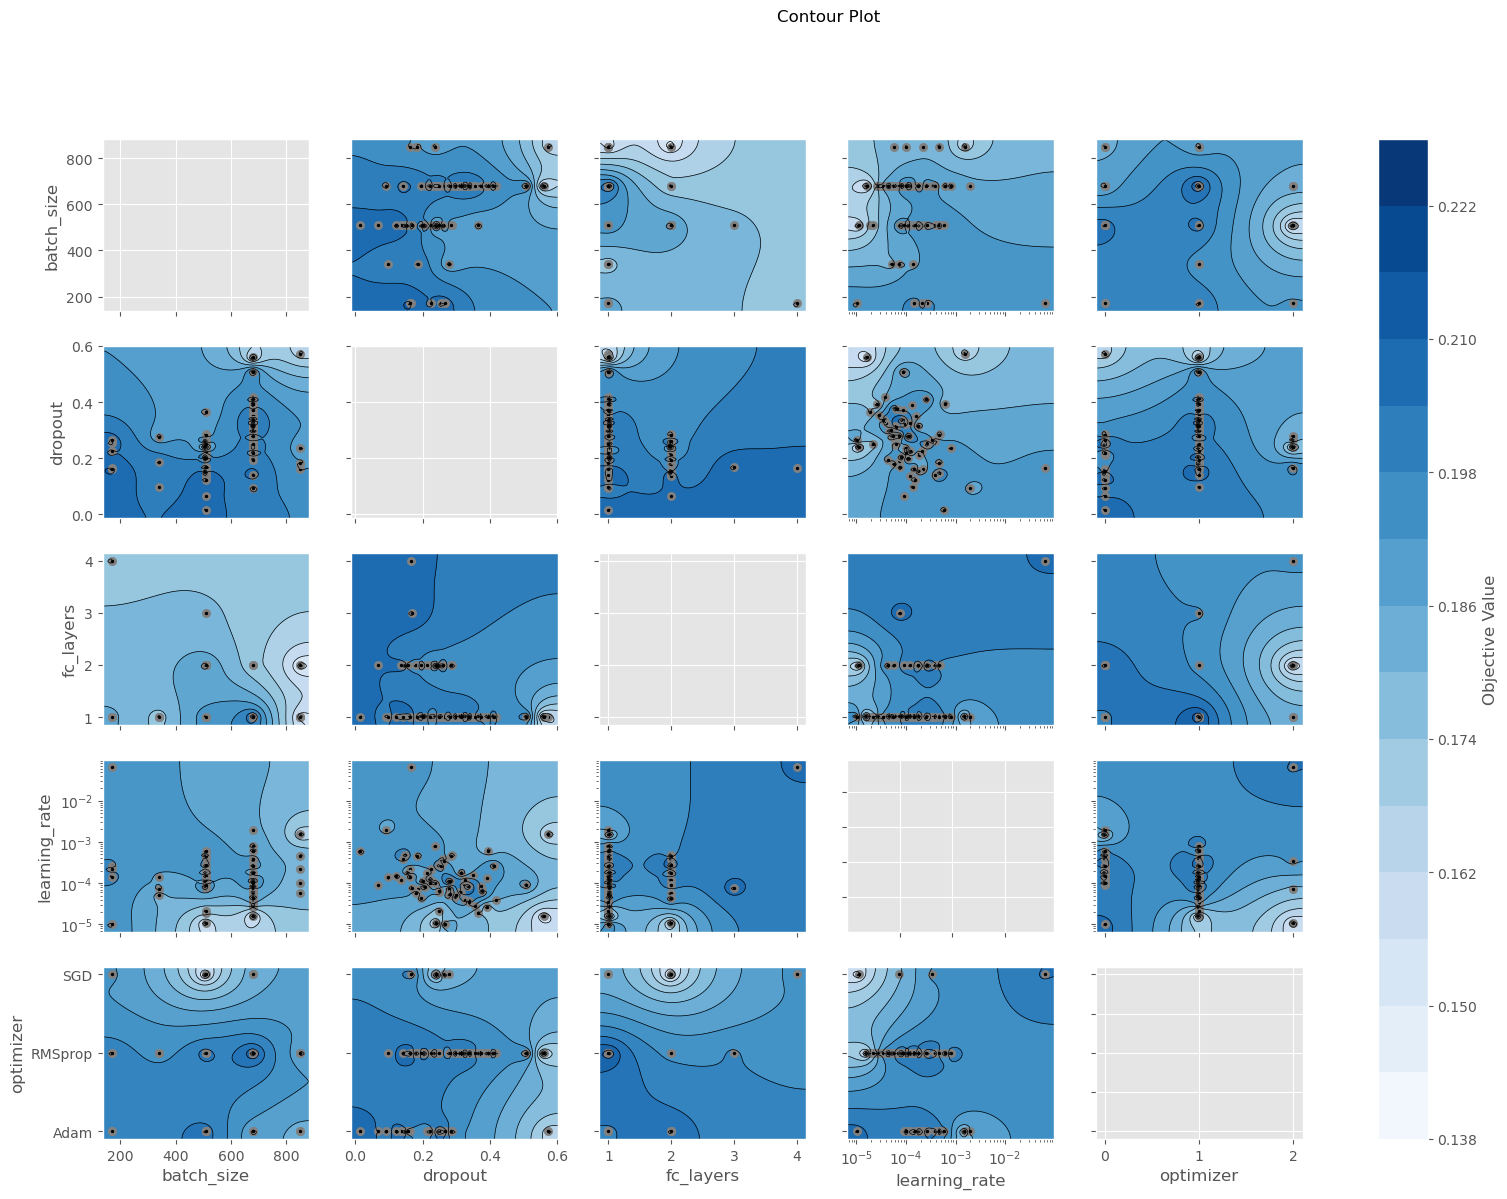

In [72]:
# Visualize hyperparameter relationships
plot_contour(study)
set_size(15, 10)

/tmp/ipykernel_41868/1888575690.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<Axes: xlabel='batch_size', ylabel='Objective Value'>,
       <Axes: xlabel='dropout'>, <Axes: xlabel='fc_layers'>,
       <Axes: xlabel='learning_rate'>, <Axes: xlabel='optimizer'>],
      dtype=object)

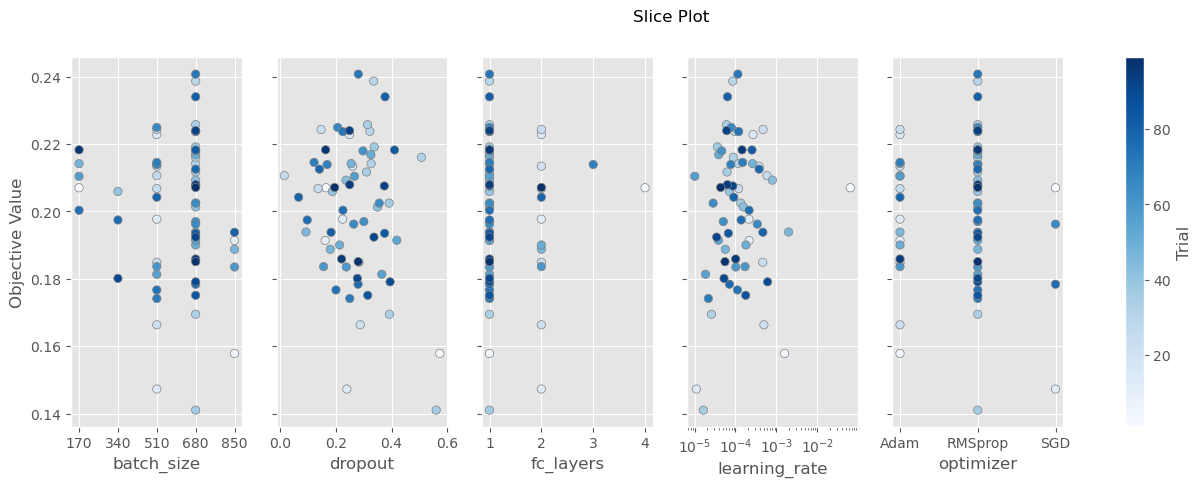

In [73]:
# Visualize individual hyperparameters as slice plot
plot_slice(study)

/tmp/ipykernel_41868/1473508994.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

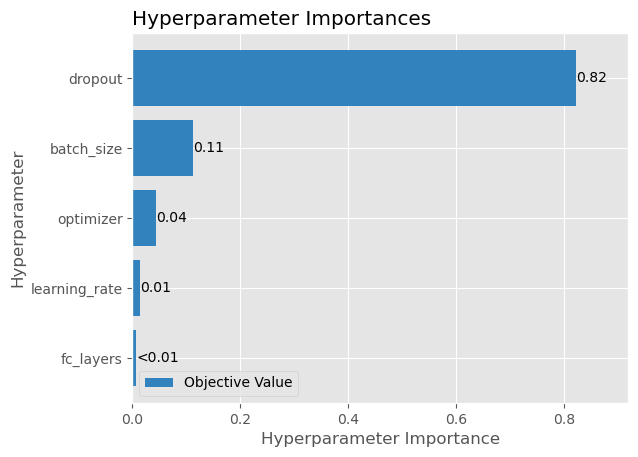

In [74]:
# Visualize parameter importances.
plot_param_importances(study)

/tmp/ipykernel_41868/3113371256.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

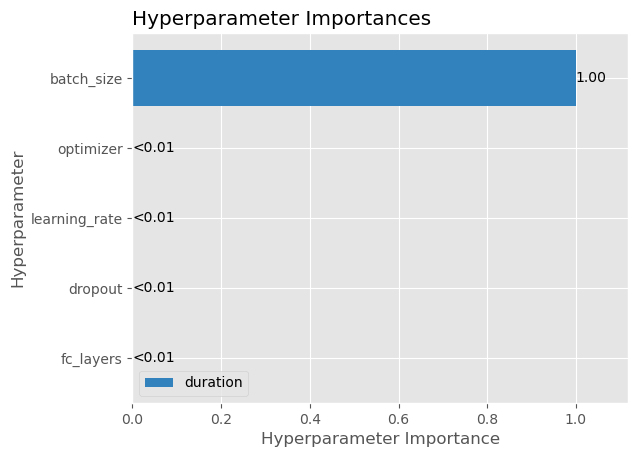

In [75]:
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

/tmp/ipykernel_41868/1828777839.py:2: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  plot_edf(study)


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

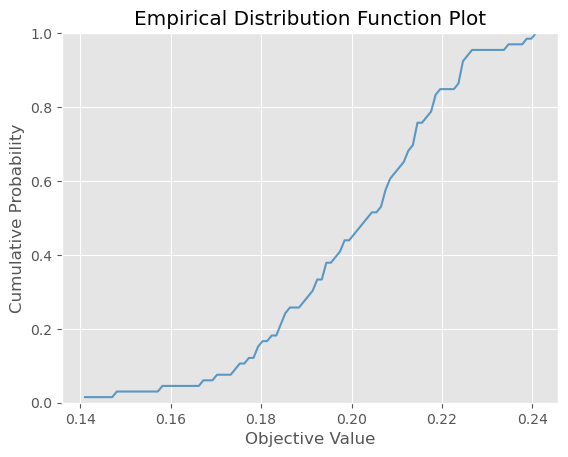

In [76]:
# Visualize empirical distribution function.
plot_edf(study)

/tmp/ipykernel_41868/1172520691.py:2: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  plot_rank(study)
[W 2024-05-23 09:45:37,318] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


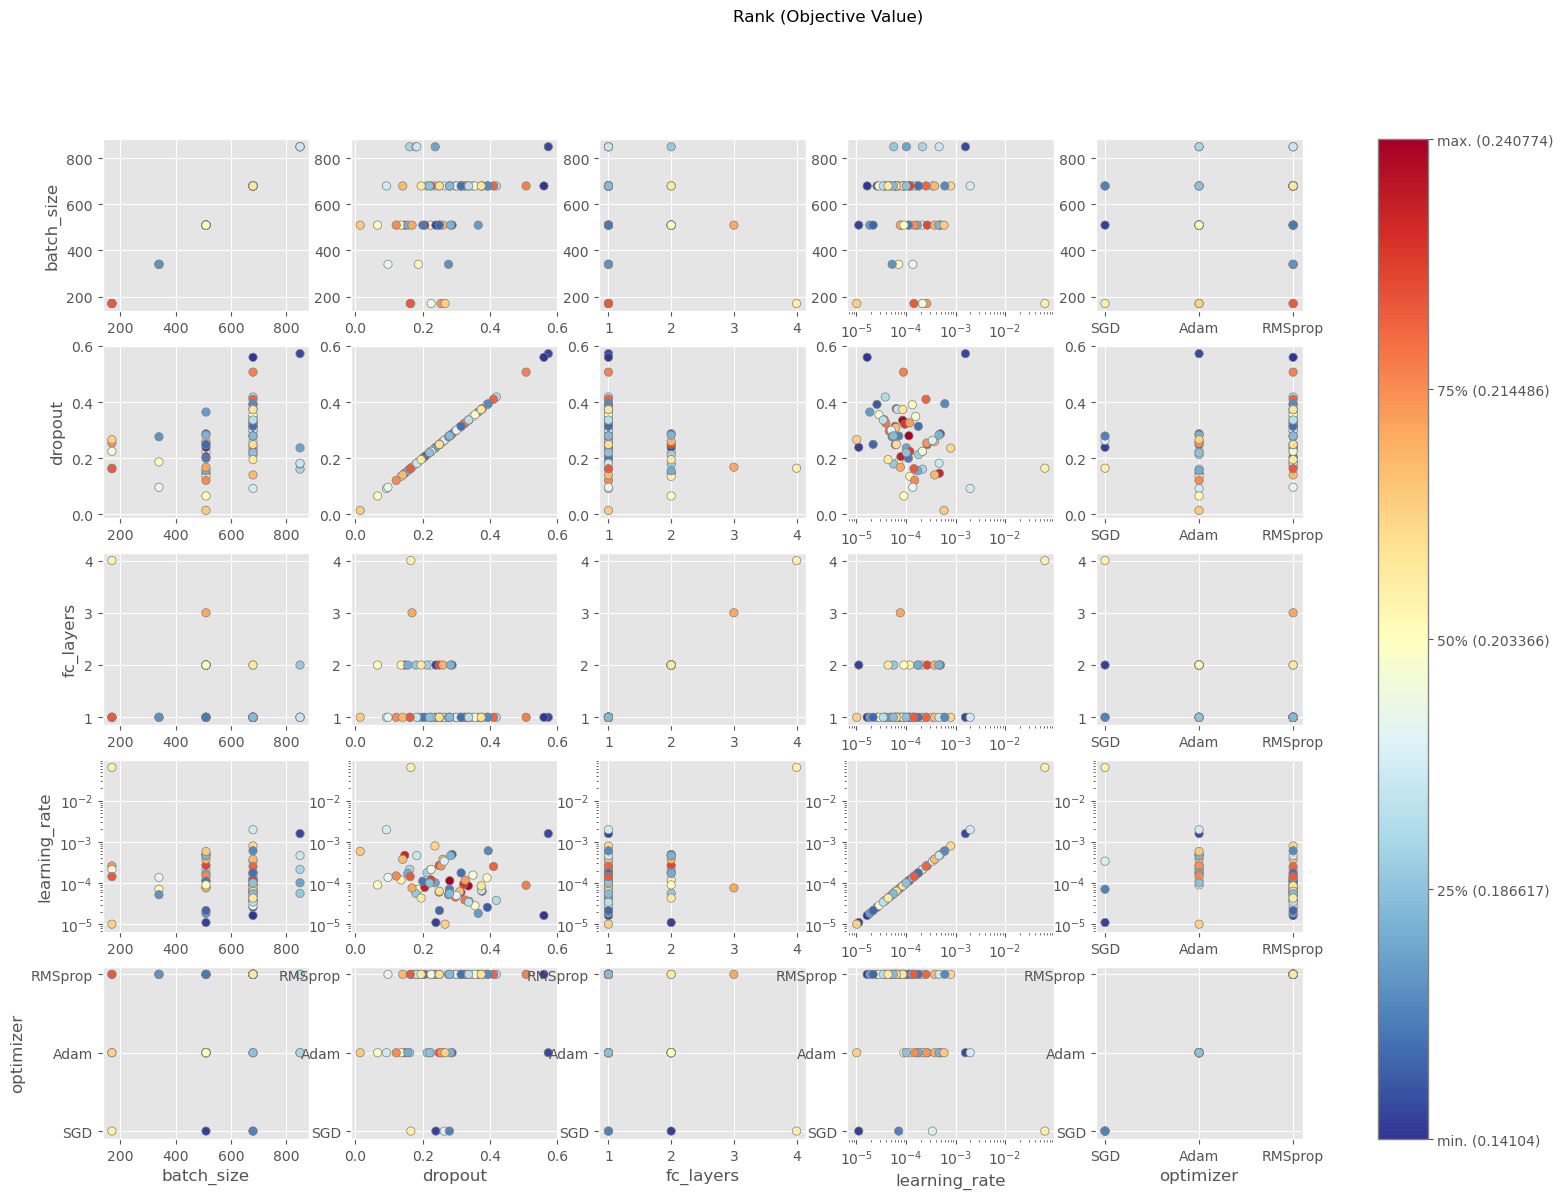

In [77]:
# Visualize parameter relations with scatter plots colored by objective values.
plot_rank(study)
set_size(15, 10)

/tmp/ipykernel_41868/124343896.py:2: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  plot_timeline(study)


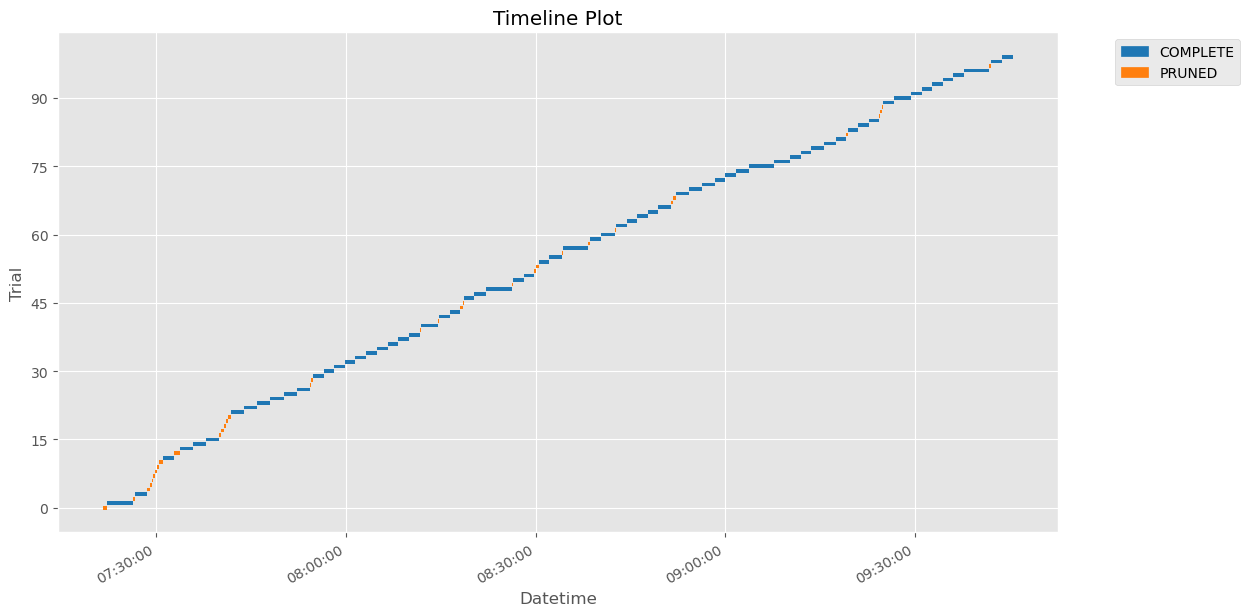

In [78]:
# Visualize the optimization timeline of performed trials.
plot_timeline(study)
set_size(10, 5)